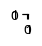

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150

sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180
# Load models together
%load_ext autoreload
%autoreload 2
    
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.sim_utils import make_dist_matrix
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.conv_models import CNNVAE, TwoStageCNNVAECLF
from src.metrics import reconstruction_accuracy, compute_cosine_distance
from src.cluster_utils import *
from src.networkx_utils import *

# Check the "best" model for NOTRIPLET VAEs


In [ ]:
def plot_pipeline_here(runs, title=None, fn=None, palette='tab10', add_clustersize=False, 
                       figsize=(9,9), legend=True, outdir = None):
    # plotting options
    sns.set_palette(palette, n_colors=len(runs.input_type.unique()))
    f, a = plt.subplots(1, 1, figsize=figsize)
    a.set_xlim([0, 1])
    a.set_ylim([0, 1])
    a.set_xlabel('Retention', fontweight='semibold', fontsize=14)
    a.set_ylabel('Mean Purity', fontweight='semibold', fontsize=14)
    # Setting major ticks
    major_ticks = np.arange(0, 1.1, 0.1)
    a.set_xticks(major_ticks)
    a.set_yticks(major_ticks)
    # Setting minor ticks
    minor_ticks = np.arange(0, 1.1, 0.05)
    a.set_xticks(minor_ticks, minor=True)
    a.set_yticks(minor_ticks, minor=True)
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    if add_clustersize:
        ax2 = a.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_yscale('log', base=2)
        ax2.set_ylabel('Mean Cluster Size (Log2)', fontweight='semibold', fontsize=14)
    for input_type in runs.input_type.unique():
        query = runs.query('input_type==@input_type')
        retentions = query['retention'][1:-1].values
        purities = query['mean_purity'][1:-1].values
        if add_clustersize:
            cluster_sizes = query['mean_cluster_size'].values[1:-1]
            
        if input_type == "TBCRalign":
            a.plot(retentions, purities, label=input_type.lstrip('_'), ls=':', c='g', lw=1)
            if add_clustersize:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='x', lw=0.25, s=6, c='g')

        elif input_type == "tcrdist3":
            a.plot(retentions, purities, label=input_type.lstrip('_'), ls=':', c='m', lw=1)
            if add_clustersize:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='.', lw=0.25, s=6, c='m')

        else:
            a.plot(retentions, purities, label=input_type.lstrip('_'), ls='--', lw=1.1)
            if add_clustersize:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='*', lw=0.25, s=6)


    a.axhline(0.6, label='60% purity cut-off', ls=':', lw=.75, c='m')
    a.axhline(0.7, label='70% purity cut-off', ls=':', lw=.75, c='c')
    a.axhline(0.8, label='80% purity cut-off', ls=':', lw=.75, c='y')
    if legend:
        a.legend(title='distance matrix', title_fontproperties={'size': 14, 'weight': 'semibold'},
             prop={'weight': 'semibold', 'size': 12}, loc='lower left')
    f.suptitle(f'{title}', fontweight='semibold', fontsize=15)
    f.tight_layout()
    if fn is not None:
        if outdir is not None:
            mkdirs(outdir)
            fn = f'{outdir}{fn}'
        f.savefig(f'{fn}.png', dpi=200)

In [ ]:
def read_results(main_folder):
    train = pd.read_csv(glob.glob(f'{main_folder}*train*.csv')[0])
    valid = pd.read_csv(glob.glob(f'{main_folder}*valid*.csv')[0])
    test = pd.read_csv(glob.glob(f'{main_folder}*test*.csv')[0])
    return train, valid, test
    
def results_pipeline(main_folder, title=None, fn=None, palette='tab10', add_clustersize=False, figsize=(9, 9), legend=True, outdir=None):
    """
    Takes the train,test,valid curves ; Gets the best in terms of valid RP p70_r35_AUC (top 3)
    And plot those curves for all 3 plots and compare
    """
    train, valid, test = read_results(main_folder)
    top3_valid = get_all_inputs_rpauc(valid.query('not input_type.str.contains("agg") and not input_type.str.contains("tcrdist") and not input_type.str.contains("TBCR")')).head(3)
    rankings = {k:f' (Top {i+1})' for i, k in enumerate(top3_valid.index)}
    train_plot = train.query('input_type in @top3_valid.index or input_type in ["TBCRalign", "tcrdist3"]')
    train_plot['name'] = train_plot['input_type'].map(rankings).replace(np.nan, '')
    train_plot['input_type'] = train_plot.apply(lambda x: x['input_type'] + x['name'], axis=1)
    valid_plot = valid.query('input_type in @top3_valid.index or input_type in ["TBCRalign", "tcrdist3"]')
    valid_plot['name'] = valid_plot['input_type'].map(rankings).replace(np.nan, '')
    valid_plot['input_type'] = valid_plot.apply(lambda x: x['input_type'] + x['name'], axis=1)
    test_plot = test.query('input_type in @top3_valid.index or input_type in ["TBCRalign", "tcrdist3"]')
    test_plot['name'] = test_plot['input_type'].map(rankings).replace(np.nan, '')
    test_plot['input_type'] = test_plot.apply(lambda x: x['input_type'] + x['name'], axis=1)
    plot_pipeline_here(train_plot.query('not (retention>0.98 and mean_purity>0.3)'),
                       f'{title}\nTrain set ; Selected best validation epochs', f'{fn}_top3ValEpochs_train_plot', palette, add_clustersize, figsize, legend, outdir)
    
    plot_pipeline_here(valid_plot.query('not (retention>0.98 and mean_purity>0.3)'),
                       f'{title}\nValid set ; Selected best validation epochs', f'{fn}_top3ValEpochs_valid_plot', palette, add_clustersize, figsize, legend, outdir)
    
    plot_pipeline_here(test_plot.query('not (retention>0.98 and mean_purity>0.3)'),
                       f'{title}\ntest set ; Selected best validation epochs', f'{fn}_top3ValEpochs_test_plot', palette, add_clustersize, figsize, legend, outdir)
    
    return train_plot, valid_plot, test_plot

In [ ]:
names = ['CNNVAE 128 NO TRP ; Binders filtered - Top 17 peps',
         'CNNVAE 128 NO TRP ; TCRBase filtered - Top 78 peps',
         'TwoStage CNNVAE 128 NO TRP ; Binders filtered - Top 17 peps',
         'TwoStage CNNVAE 128 NO TRP ; TCRBase filtered - Top 78 peps']
filenames = ['CNNVAE_128_Top17peps_NoTrp', 
             'CNNVAE_128_Top78peps_NoTrp', 
             'TwoStage_128_Top17peps_NoTrp', 
             'TwoStage_128_Top78peps_NoTrp']
files = sorted(glob.glob('../output/240618_NestedKCV_CNNVAE/clustering/*NOTRIPLET*/'))

for name, filename, main_folder in zip(names, filenames, files):
    results_pipeline(main_folder, title=name, fn=filename, outdir='../output/240618_NestedKCV_CNNVAE/figs/')

# TCRbase detour

In [2]:
exp_swap = pd.read_csv('../data/filtered/240326_nettcr_exp_paired_withswaps.csv')
old_swap = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv')

In [3]:
from sklearn.metrics import roc_auc_score
from src.metrics import get_metrics
def read_tcrbase_results(peptide, original_df, partition=0, dir='../output/TCRBASE/tcrbase_expanded_ALL_swapped/'):
    cols = ['xx', 'xy', 'id_query'] + [f'q_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['bs1', 'hit', 'id_db'] + [f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['score', 'bs2']
    df = pd.read_csv(f'{dir}{peptide}_p{partition}.txt', comment='#', sep='\s', header=None, names=cols)
    df['q_seq'] = df['q_A1']+df['q_A2']+df['q_A3']+df['q_B1']+df['q_B2']+df['q_B3']
    original_df = original_df.query('peptide==@peptide and partition==@partition')
    original_df['q_seq'] = original_df['A1']+original_df['A2']+original_df['A3']+original_df['B1']+original_df['B2']+original_df['B3']
    results = pd.merge(df.set_index('q_seq')[['score', 'id_db']+[f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']]],
                       original_df.set_index('q_seq')[['partition','binder', 'peptide', 'A1','A2','A3','B1','B2','B3']],
                       left_index=True, right_index=True)
    print(peptide, round(roc_auc_score(results['binder'], results['score']),4))
    tcrbase_metrics = {'peptide':peptide, 
                       'method':'tcrbase',
                       'n_pos':len(original_df.query('original_peptide==@peptide and partition==@partition'))}
    tcrbase_metrics.update(get_metrics(results['binder'], results['score'], round_digit=5))
    print(tcrbase_metrics)
    return tcrbase_metrics, results
        

In [4]:
total_exp=[]
total_old=[]
for partition in range(5):
    exp_results = []
    for p in exp_swap.peptide.unique():
        x, _ = read_tcrbase_results(p, exp_swap, partition=partition, dir='../output/TCRBASE/tcrbase_expanded_ALL_swapped/')
        exp_results.append(x)    
    exp_results = pd.DataFrame(exp_results)
    
    old_results = []
    for p in old_swap.peptide.unique():
        x, _ = read_tcrbase_results(p, old_swap, partition=partition, dir='../output/TCRBASE/tcrbase_old_ALL_swapped/')
        old_results.append(x)    
    old_results = pd.DataFrame(old_results)
    total_exp.append(exp_results.assign(partition=partition))
    total_old.append(old_results.assign(partition=partition))
    exp_results.sort_values('n_pos', ascending=False).to_csv(f'../output/TCRBASE/results_exp_partition_p{partition}.csv', index=False)
    old_results.sort_values('n_pos', ascending=False).to_csv(f'../output/TCRBASE/results_old_partition_p{partition}.csv', index=False)

AVFDRKSDAK 0.4855
{'peptide': 'AVFDRKSDAK', 'method': 'tcrbase', 'n_pos': 143, 'auc': 0.48551, 'auc_01': 0.50745, 'auc_01_real': 0.06416, 'precision': 0.16628, 'recall': 1.0, 'accuracy': 0.16628, 'AP': 0.18505}
KLGGALQAK 0.6103
{'peptide': 'KLGGALQAK', 'method': 'tcrbase', 'n_pos': 181, 'auc': 0.6103, 'auc_01': 0.55241, 'auc_01_real': 0.14958, 'precision': 0.16728, 'recall': 1.0, 'accuracy': 0.16728, 'AP': 0.29468}
ELAGIGILTV 0.932
{'peptide': 'ELAGIGILTV', 'method': 'tcrbase', 'n_pos': 92, 'auc': 0.93198, 'auc_01': 0.80832, 'auc_01_real': 0.63581, 'precision': 0.16758, 'recall': 1.0, 'accuracy': 0.16758, 'AP': 0.80004}
TTDPSFLGRY 0.6819
{'peptide': 'TTDPSFLGRY', 'method': 'tcrbase', 'n_pos': 78, 'auc': 0.68187, 'auc_01': 0.61969, 'auc_01_real': 0.27741, 'precision': 0.16774, 'recall': 1.0, 'accuracy': 0.16774, 'AP': 0.44064}
RAKFKQLL 0.8805
{'peptide': 'RAKFKQLL', 'method': 'tcrbase', 'n_pos': 166, 'auc': 0.88051, 'auc_01': 0.80623, 'auc_01_real': 0.63184, 'precision': 0.16667, 'recal

In [5]:
pd.concat(total_exp).drop(columns=['method']).groupby('peptide').mean().sort_values('n_pos',ascending=False).to_csv(f'../output/TCRBASE/total_mean_exp_results.csv', index=True)
pd.concat(total_old).drop(columns=['method']).groupby('peptide').mean().sort_values('n_pos',ascending=False).to_csv(f'../output/TCRBASE/total_mean_old_results.csv', index=True)

In [6]:
total_exp = pd.concat(total_exp).drop(columns=['method']).groupby('peptide').mean()
total_old = pd.concat(total_old).drop(columns=['method']).groupby('peptide').mean()

In [18]:
exp_filt = total_exp.query('n_pos>=75').sort_values('auc',ascending=False).head(17).index
xd=total_exp.query('n_pos>75').sort_values('auc',ascending=False).head(17).sort_index()
xd2=xd.rename(columns={'n_pos':'N binders', 'auc' : 'TCRBase AUC', 'auc_01_real' : 'TCRBase AUC 01'})\
      .drop(columns=['auc_01','precision','recall','accuracy','AP','partition']).sort_values('N binders')
xd2.columns = pd.MultiIndex.from_tuples([('Mean over 5 partitions', x) for x in xd2.columns])
display(xd2)


Mean over 5 partitions                           
                        N binders TCRBase AUC TCRBase AUC 01
peptide                                                     
TTDPSFLGRY                   77.4    0.672200       0.301454
YLQPRTFLL                    79.8    0.731442       0.420246
SPRWYFYYL                    89.8    0.671422       0.334904
ELAGIGILTV                   91.4    0.913552       0.638514
AVFDRKSDAK                  143.4    0.537760       0.094672
RAKFKQLL                    166.0    0.901230       0.684024
KLGGALQAK                   180.2    0.583082       0.167164
GILGFVFTL                   233.0    0.829168       0.515450

In [19]:
top17 = pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_POSONLY.csv').peptide.unique()

xd3=total_exp.query('peptide in @top17').sort_values('auc',ascending=False).head(17).sort_index()
xd4=xd3.rename(columns={'n_pos':'N binders', 'auc' : 'TCRBase AUC', 'auc_01_real' : 'TCRBase AUC 01'})\
      .drop(columns=['auc_01','precision','recall','accuracy','AP','partition']).sort_values('N binders')
xd4.columns = pd.MultiIndex.from_tuples([('Mean over 5 partitions', x) for x in xd4.columns] )
display(xd4)


Mean over 5 partitions                           
                        N binders TCRBase AUC TCRBase AUC 01
peptide                                                     
ATDALMTGF                    20.6    0.830942       0.594026
KTFPPTEPK                    23.8    0.497278       0.118092
LTDEMIAQY                    25.8    0.642864       0.295822
QYIKWPWYI                    26.4    0.677248       0.360522
CINGVCWTV                    45.2    0.769272       0.452496
GLCTLVAML                    54.2    0.896446       0.638464
IVTDFSVIK                    63.2    0.669602       0.337884
NLVPMVATV                    73.6    0.608004       0.229924
LLWNGPMAV                    74.2    0.880110       0.686154
TTDPSFLGRY                   77.4    0.672200       0.301454
YLQPRTFLL                    79.8    0.731442       0.420246
SPRWYFYYL                    89.8    0.671422       0.334904
ELAGIGILTV                   91.4    0.913552       0.638514
AVFDRKSDAK                  143.4    0.537760       0.094672
RAKFKQLL                    166.0    0.901230       0.684024
KLGGALQAK                   180.2    0.583082       0.167164
GILGFVFTL                   233.0    0.829168       0.515450

In [21]:
xd2.to_csv('../../../writing/VAE_TCR_DRAFT/tables/8peptides_list.csv')
xd4.to_csv('../../../writing/VAE_TCR_DRAFT/tables/17peptides_list.csv')

# inits

In [ ]:
exp_df = pd.read_csv('../data/multimodal/240311_nettcr_pairedAB_expanded_noswap.csv')
exp78 = pd.read_csv('../data/filtered/240507_nettcr_exp_pruned_noswap_78peps.csv')
exp17 = pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_POSONLY.csv')
old_df = pd.read_csv('../data/filtered/240416_nettcr_old_26pep_no_swaps.csv')
old15 = pd.read_csv('../data/filtered/240416_nettcr_old_top15peps_no_swaps.csv')
old20 = pd.read_csv('../data/filtered/240507_nettcr_old_pruned_noswap_20peps.csv')

In [ ]:
def get_agg_matrix(dm_vae, dm_base, index_col='raw_index', cols = ('peptide', 'original_peptide','raw_index', 'binder', 'partition')):
    if not all([x==y for x,y in zip(dm_vae[index_col].values, dm_base[index_col].values)]):
        dm_base, values_base = resort_baseline(dm_base, dm_vae, index_col)
    else:
        values_base = None
    values_vae = dm_vae.iloc[:len(dm_vae), :len(dm_vae)].values
    if values_base is None:
        values_base = dm_base.iloc[:len(dm_base), :len(dm_base)].values
    assert all([x==y for x,y in zip(dm_vae[index_col].values, dm_base[index_col].values)]) and len(dm_vae)==len(dm_base)
    agg_values = 1-np.multiply(1-values_vae, 1-values_base)
    agg_dm = pd.DataFrame(agg_values)
    agg_dm[list(cols)] = dm_vae[list(cols)].values
    return agg_dm, agg_dm.iloc[:len(agg_dm), :len(agg_dm)].values

In [ ]:
dm_tbcr = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/2404XX_OUTPUT_tbcralign_distmatrix_140peps_labeled.csv', index_col=0)
dm_tcrdist = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/tcrdist3_distmatrix_140peps_new_labeled.csv', index_col=0)

In [ ]:
model_ts128 = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj/epoch_5000_interval_checkpoint__kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj.pt',
                              '../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj/checkpoint_best_kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj_JSON_kwargs.json',
                              map_location='cpu', verbose=False)
model_os128 = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1607_ER8wJ/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1607_ER8wJ.pt',
                              '../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1607_ER8wJ/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1607_ER8wJ_JSON_kwargs.json',
                              map_location='cpu', verbose=False)
model_os256 = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02/epoch_8000_interval_checkpoint__fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02.pt',
                              '../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02_JSON_kwargs.json',
                              map_location='cpu', verbose=False)

model_ts128_notrp = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1232_ph8wm/epoch_4000_interval_checkpoint__kcv_fold_00_Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1232_ph8wm.pt',
                                    '../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1232_ph8wm/checkpoint_best_kcv_fold_00_Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1232_ph8wm_JSON_kwargs.json',
                                    map_location='cpu', verbose=False)
model_os128_notrp = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni.pt',
                                    '../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni_JSON_kwargs.json',
                              map_location='cpu', verbose=False)

# MST & cuts - Redo filtered runs

## Test set, Subsampled + Filtered to some peps

### Data reading and sorting

In [ ]:
import random
seed=1
random.seed(seed)
# See TCRBase detour for exp_filt
print(exp_filt)
df = exp17.query('peptide in @exp_filt and partition==1')
testset_subsample = []
for p in exp_filt:
    tmp = df.query('peptide==@p')
    testset_subsample.append(tmp.sample(min(len(tmp), random.randint(70,90)), random_state=seed))
df = pd.concat(testset_subsample)
df_idx = df['raw_index'].unique()
df.groupby('peptide').agg(count=('A1','count'))

In [ ]:
# Best model picked on validation performance
latent_ts128 = get_latent_df(model_ts128, df)
latent_os128 = get_latent_df(model_os128, df)
latent_os256 = get_latent_df(model_os256, df)
dm_ts128, values_ts128, feats, labels, enc_labels, lab_enc = get_distances_labels_from_latent(latent_ts128, index_col='raw_index')
dm_os128, values_os128, feats, labels, enc_labels, lab_enc = get_distances_labels_from_latent(latent_os128, index_col='raw_index')
dm_os256, values_os256, feats, labels, enc_labels, lab_enc = get_distances_labels_from_latent(latent_os256, index_col='raw_index')
# Assert all index are in the same order prior to refiltering+resorting the baselines
assert all(dm_os128.raw_index == dm_os256.raw_index) and all(dm_ts128.raw_index == dm_os256.raw_index) and all(dm_ts128.raw_index == dm_os128.raw_index), 'wtf'
# re-get the baseline and re-filter based on the subset test set
dm_tbcr_testset = dm_tbcr.query('raw_index in @df_idx')
dm_tcrdist_testset = dm_tcrdist.query('raw_index in @df_idx')
# Resort it just so that we can re-use the labels and indices in the same order
dm_tbcr_testset, values_tbcr_testset = resort_baseline(dm_tbcr_testset, dm_ts128, 'raw_index')
dm_tcrdist_testset, values_tcrdist_testset = resort_baseline(dm_tcrdist_testset, dm_ts128, 'raw_index')
print(len(dm_tbcr_testset), len(dm_tcrdist_testset), len(dm_ts128), len(dm_os128), len(dm_os256))

In [ ]:
# Aggregate the "best" model which is the two-stage 128 and the TBCRalign matrix
dm_agg, values_agg = get_agg_matrix(dm_ts128, dm_tbcr_testset)
print(len(dm_tbcr_testset), len(dm_tcrdist_testset), len(dm_ts128), len(dm_os128), len(dm_os256), len(dm_agg))

### dist matrix plotting detour

In [ ]:
def sort_dm(dm, cols=('peptide','partition','binder','origin','raw_index','original_peptide')):
    return dm.sort_values('peptide', ascending=True)[list(dm.sort_values('peptide',ascending=True).index)+list(cols)]
    

In [ ]:
sorted_dm_ts128 = sort_dm(dm_ts128)
sorted_values_ts128 = sorted_dm_ts128.iloc[:len(sorted_dm_ts128), :len(sorted_dm_ts128)].values
sorted_dm_os128 = sort_dm(dm_os128)
sorted_values_os128 = sorted_dm_os128.iloc[:len(sorted_dm_os128), :len(sorted_dm_os128)].values
sorted_dm_os256 = sort_dm(dm_os256)
sorted_values_os256 = sorted_dm_os256.iloc[:len(sorted_dm_os256), :len(sorted_dm_os256)].values
sorted_dm_tbcr_testset, sorted_values_tbcr_testset = resort_baseline(dm_tbcr_testset, sorted_dm_ts128, 'raw_index')
sorted_dm_tcrdist_testset, sorted_values_tcrdist_testset = resort_baseline(dm_tcrdist_testset, sorted_dm_ts128, 'raw_index')

In [ ]:
sorted_dm_ts128_notrp = sort_dm(dm_ts128_notrp)
sorted_values_ts128_notrp = sorted_dm_ts128_notrp.iloc[:len(sorted_dm_ts128_notrp), :len(sorted_dm_ts128_notrp)].values

sorted_dm_os128_notrp = sort_dm(dm_os128_notrp)
sorted_values_os128_notrp = sorted_dm_os128_notrp.iloc[:len(sorted_dm_ts128_notrp), :len(sorted_dm_ts128_notrp)].values

In [ ]:
pepmap = sorted_dm_ts128_notrp.groupby('peptide').agg(count=('raw_index','count'))
pepmap['idx']=pepmap['count'].cumsum()
pepmap['tick']=pepmap['idx']-pepmap['count'].iloc[0]+3
tickmarks = pepmap['tick'].to_dict() 
idxs = pepmap['idx'].to_dict()

In [ ]:
tickmarks

In [ ]:
f,ax = plt.subplots(1,2, figsize=(16,16), width_ratios=(16.5/17, 0.5/17))
ax = ax.ravel()
ax, cbar_ax = ax[0], ax[1]
sns.heatmap(sorted_values_ts128_notrp, ax=ax, square=True, cbar_ax=cbar_ax)
ax.set_xticks(list(tickmarks.values()))
ax.set_yticks(list(tickmarks.values()))

ax.set_xticklabels(list(tickmarks.keys()), ha='center', fontweight='semibold', fontsize=15)
ax.set_yticklabels(list(tickmarks.keys()), va='center', fontweight='semibold', fontsize=15)
for k,v in idxs.items():
    ax.axhline(v, ls='--', lw=.9, c='b')
    ax.axvline(v, ls='--', lw=.9, c='b')
# Rotate the tick labels for better readability (optional)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
ax.set_title('Two Stage VAE dist matrix', fontweight='semibold', fontsize=17)
f.tight_layout()
f.savefig('../output/240618_NestedKCV_CNNVAE/notebook_figs/240729_ts128_NOTRP_test_distmatrix.png', dpi=150, bbox_inches='tight')

In [ ]:
f,ax = plt.subplots(1,2, figsize=(16,16), width_ratios=(16.5/17, 0.5/17))
ax = ax.ravel()
ax, cbar_ax = ax[0], ax[1]
sns.heatmap(sorted_values_os128_notrp, ax=ax, square=True, cbar_ax=cbar_ax)
ax.set_xticks(list(tickmarks.values()))
ax.set_yticks(list(tickmarks.values()))

ax.set_xticklabels(list(tickmarks.keys()), ha='center', fontweight='semibold', fontsize=15)
ax.set_yticklabels(list(tickmarks.keys()), va='center', fontweight='semibold', fontsize=15)
for k,v in idxs.items():
    ax.axhline(v, ls='--', lw=.9, c='b')
    ax.axvline(v, ls='--', lw=.9, c='b')
# Rotate the tick labels for better readability (optional)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
ax.set_title('Two Stage VAE dist matrix', fontweight='semibold', fontsize=17)
f.tight_layout()
f.savefig('../output/240618_NestedKCV_CNNVAE/notebook_figs/240729_os128_NOTRP_test_distmatrix.png', dpi=150, bbox_inches='tight')

In [ ]:
f,ax = plt.subplots(1,2, figsize=(16,16), width_ratios=(16.5/17, 0.5/17))
ax = ax.ravel()
ax, cbar_ax = ax[0], ax[1]
sns.heatmap(sorted_values_ts128, ax=ax, square=True, cbar_ax=cbar_ax)
ax.set_xticks(list(tickmarks.values()))
ax.set_yticks(list(tickmarks.values()))

ax.set_xticklabels(list(tickmarks.keys()), ha='center', fontweight='semibold', fontsize=15)
ax.set_yticklabels(list(tickmarks.keys()), va='center', fontweight='semibold', fontsize=15)
for k,v in idxs.items():
    ax.axhline(v, ls='--', lw=.9, c='b')
    ax.axvline(v, ls='--', lw=.9, c='b')
# Rotate the tick labels for better readability (optional)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
ax.set_title('Two Stage VAE dist matrix', fontweight='semibold', fontsize=17)
f.tight_layout()
f.savefig('../output/240618_NestedKCV_CNNVAE/notebook_figs/240729_ts128_test_distmatrix.png', dpi=150, bbox_inches='tight')

In [ ]:
f,ax = plt.subplots(1,2, figsize=(16,16), width_ratios=(16.5/17, 0.5/17))
ax = ax.ravel()
ax, cbar_ax = ax[0], ax[1]
sns.heatmap(sorted_values_tbcr_testset, ax=ax, square=True, cbar_ax=cbar_ax)
ax.set_xticks(list(tickmarks.values()))
ax.set_yticks(list(tickmarks.values()))

ax.set_xticklabels(list(tickmarks.keys()), ha='center', fontweight='semibold', fontsize=15)
ax.set_yticklabels(list(tickmarks.keys()), va='center', fontweight='semibold', fontsize=15)
for k,v in idxs.items():
    ax.axhline(v, ls='--', lw=.9, c='b')
    ax.axvline(v, ls='--', lw=.9, c='b')
# Rotate the tick labels for better readability (optional)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
ax.set_title('TBCRalign dist matrix', fontweight='semibold', fontsize=17)
f.tight_layout()
f.savefig('../output/240618_NestedKCV_CNNVAE/notebook_figs/240729_tbcr_test_distmatrix.png', dpi=150, bbox_inches='tight')

In [ ]:
sns.heatmap(dm_tbcr_testset.query('peptide in ["ELAGIGILTV", "GILGFVFTL"]').iloc[:len()

In [ ]:
xd=dm_tbcr_testset.query('peptide in ["ELAGIGILTV", "GILGFVFTL"]')
xd = xd[[str(x) for x in xd.index]].values
sns.heatmap(xd)

In [ ]:
wtf=sorted_dm_tbcr_testset.query('peptide in ["ELAGIGILTV", "GILGFVFTL"]')
wtf = wtf[[str(x) for x in wtf.index]+['peptide','raw_index']]

In [ ]:
wtf.iloc[40:80, 40:82]

### params

In [ ]:
initial_cut_threshold=1
initial_cut_method='top'
filename='240715_8peps_subsampled_partition1_test_'

### Running the algos for baselines

In [ ]:
# TBCRALIGN

G, tree, dist_matrix, values_tbcr_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_tbcr_testset, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, tbcr_it_scores, tbcr_it_purities, tbcr_it_rets = iterative_size_cut(values_tbcr_testset, tree, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, tbcr_sh_scores, tbcr_sh_purities, tbcr_sh_rets = iterative_topn_cut(values_tbcr_testset, tree, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))

# Running TCRdist distmatrix
G, tree, dist_matrix, values_tcrdist_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_tcrdist_testset, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, tcrdist_it_scores, tcrdist_it_purities, tcrdist_it_rets = iterative_size_cut(values_tcrdist_testset, tree, 
                                                                                                                                 initial_cut_threshold=initial_cut_threshold, 
                                                                                                                                 initial_cut_method=initial_cut_method, 
                                                                                                                                 top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, tcrdist_sh_scores, tcrdist_sh_purities, tcrdist_sh_rets = iterative_topn_cut(values_tcrdist_testset, tree, 
                                                                                                                                            initial_cut_threshold=initial_cut_threshold, 
                                                                                                                                            initial_cut_method=initial_cut_method, 
                                                                                                                                            top_n=1, which='edge', weighted=True, 
                                                                                                                                            verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))

### Running for VAEs

In [ ]:
# Two-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G, tree, dist_matrix, values_ts128_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_ts128, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, it_scores_ts128, it_purities_ts128, it_rets_ts128 = iterative_size_cut(values_ts128_testset, tree, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, sh_scores_ts128, sh_purities_ts128, sh_rets_ts128 = iterative_topn_cut(values_ts128_testset, tree, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))


In [ ]:
# One-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G, tree, dist_matrix, values_os128_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_os128, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, it_scores_os128, it_purities_os128, it_rets_os128 = iterative_size_cut(values_os128_testset, tree, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, sh_scores_os128, sh_purities_os128, sh_rets_os128 = iterative_topn_cut(values_os128_testset, tree, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))


In [ ]:
# One-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G, tree, dist_matrix, values_os256_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_os256, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, it_scores_os256, it_purities_os256, it_rets_os256 = iterative_size_cut(values_os256_testset, tree, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, sh_scores_os256, sh_purities_os256, sh_rets_os256 = iterative_topn_cut(values_os256_testset, tree, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))


### Run the aggregate

In [ ]:
# One-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G, tree, dist_matrix, values_agg_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_agg, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, it_scores_agg, it_purities_agg, it_rets_agg = iterative_size_cut(values_agg_testset, tree, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, sh_scores_agg, sh_purities_agg, sh_rets_agg = iterative_topn_cut(values_agg_testset, tree, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))


NameError: name 'size_clusters' is not defined

In [ ]:
ts128_cluster_testset = cluster_all_thresholds(values_ts128_testset, values_ts128_testset, labels, encoded_labels, label_encoder, n_jobs=8)
os128_cluster_testset = cluster_all_thresholds(values_os128_testset, values_os128_testset, labels, encoded_labels, label_encoder, n_jobs=8)
os256_cluster_testset = cluster_all_thresholds(values_os256_testset, values_os256_testset, labels, encoded_labels, label_encoder, n_jobs=8)
tcrdist_cluster_testset = cluster_all_thresholds(values_tcrdist_testset, values_tcrdist_testset, labels, encoded_labels, label_encoder, n_jobs=8)
tbcr_cluster_testset = cluster_all_thresholds(values_tbcr_testset, values_tbcr_testset, labels, encoded_labels, label_encoder, n_jobs=8)
agg_cluster_testset = cluster_all_thresholds(values_agg_testset, values_agg_testset, labels, encoded_labels, label_encoder, n_jobs=8)

In [ ]:
test_clustering = pd.concat([ts128_cluster_testset.assign(dist_matrix='ts128', method='agglomerative'), 
                                os128_cluster_testset.assign(dist_matrix='os128', method='agglomerative'), 
                                os256_cluster_testset.assign(dist_matrix='os256', method='agglomerative'), 
                                tcrdist_cluster_testset.assign(dist_matrix='tcrdist', method='agglomerative'), 
                                tbcr_cluster_testset.assign(dist_matrix='tbcr', method='agglomerative'), 
                                agg_cluster_testset.assign(dist_matrix='agg', method='agglomerative')])
test_clustering = pd.concat([test_clustering, 
           pd.concat([pd.DataFrame(np.array([sh_rets_ts128, sh_purities_ts128, sh_scores_ts128]).T, 
             columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='ts128', method='MST_size_cut'),
           pd.DataFrame(np.array([sh_rets_os128, sh_purities_os128, sh_scores_os128]).T, 
                        columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='os128', method='MST_size_cut'),
           pd.DataFrame(np.array([sh_rets_os256, sh_purities_os256, sh_scores_os256]).T, 
                        columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='os256', method='MST_size_cut'),
           pd.DataFrame(np.array([sh_rets_agg, sh_purities_agg, sh_scores_agg]).T, 
                        columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='agg', method='MST_size_cut'),
           pd.DataFrame(np.array([tbcr_sh_rets, tbcr_sh_purities, tbcr_sh_scores]).T, 
                        columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='tbcr', method='MST_size_cut'),
           pd.DataFrame(np.array([tcrdist_sh_rets, tcrdist_sh_purities, tcrdist_sh_scores]).T, 
                        columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='tcrdist', method='MST_size_cut')])]).assign(dataset='8peps', partition='test', fold=1)

### silhouette score plots

In [ ]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning ; Using Top-5 as initial cut ; distance-weighted betweenness\nTBCR comparison of size-cut and top-1 (silhouette) cut')

a.plot(range(len(tbcr_it_purities)), tbcr_it_purities, lw=.75, ls=':', c='m',
       label='TBCR size(4)-cut avg purity')
a.plot(range(len(tbcr_it_rets)), tbcr_it_rets, lw=.75, ls='-', c='m',
       label='TBCR size(4)-cut avg retention')
a2.plot(range(len(tbcr_it_scores)), tbcr_it_scores, lw=.75, ls='--', c='m',
       label='TBCR size(4)-cut silhouette score')

a.plot(range(len(tbcr_sh_purities)), tbcr_sh_purities, lw=1, ls=':', c='g',
       label='TBCR Top1-cut avg purity')
a.plot(range(len(tbcr_sh_rets)), tbcr_sh_rets, lw=.75, ls='-', c='g',
       label='TBCR Top1-cut avg retention')
a2.plot(range(len(tbcr_sh_scores)), tbcr_sh_scores, lw=.8, ls='--', c='g',
       label='TBCR Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.88))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}TBCR_silhouette.png', dpi=150, bbox_inches='tight')


In [ ]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning ; Using Top-5 as initial cut ; distance-weighted betweenness\ntcrdist3 comparison of size-cut and top-1 (silhouette) cut')

a.plot(range(len(tcrdist_it_purities)), tcrdist_it_purities, lw=.75, ls=':', c='c',
       label='tcrdist3 size(4)-cut avg purity')
a.plot(range(len(tcrdist_it_rets)), tcrdist_it_rets, lw=.75, ls='-', c='c',
       label='tcrdist3 size(4)-cut avg retention')
a2.plot(range(len(tcrdist_it_scores)), tcrdist_it_scores, lw=.75, ls='--', c='c',
       label='tcrdist3 size(4)-cut silhouette score')

a.plot(range(len(tcrdist_sh_purities)), tcrdist_sh_purities, lw=1, ls=':', c='y',
       label='tcrdist3 Top1-cut avg purity')
a.plot(range(len(tcrdist_sh_rets)), tcrdist_sh_rets, lw=.75, ls='-', c='y',
       label='tcrdist3 Top1-cut avg retention')
a2.plot(range(len(tcrdist_sh_scores)), tcrdist_sh_scores, lw=.8, ls='--', c='y',
       label='tcrdist3 Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.88))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}tcrdist3_silhouette.png', dpi=150, bbox_inches='tight')


In [ ]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning TwoStage 128 ; Using Top-5 as initial cut ; distance-weighted betweenness\nVAE comparison of size-cut and top-1 (silhouette) cut')
a.plot(range(len(it_purities_ts128)), it_purities_ts128, lw=1, ls=':', c='b',
       label='VAE size(4)-cut avg purity')
a.plot(range(len(it_rets_ts128)), it_rets_ts128, lw=.75, ls='-', c='b',
       label='VAE size(4)-cut avg retention')
a2.plot(range(len(it_scores_ts128)), it_scores_ts128, lw=.8, ls='--', c='b',
       label='VAE size(4)-cut silhouette score')

a.plot(range(len(sh_purities_ts128)), sh_purities_ts128, lw=.75, ls=':', c='r',
       label='VAE Top1-cut avg purity')
a.plot(range(len(sh_rets_ts128)), sh_rets_ts128, lw=.75, ls='-', c='r',
       label='VAE Top1-cut avg retention')
a2.plot(range(len(sh_scores_ts128)), sh_scores_ts128, lw=.75, ls='--', c='r',
       label='VAE Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.8))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}_ts128_silhouette.png', dpi=150, bbox_inches='tight')


In [ ]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning OneStage 128 ; Using Top-5 as initial cut ; distance-weighted betweenness\nVAE comparison of size-cut and top-1 (silhouette) cut')
a.plot(range(len(it_purities_os128)), it_purities_os128, lw=1, ls=':', c='b',
       label='VAE size(4)-cut avg purity')
a.plot(range(len(it_rets_os128)), it_rets_os128, lw=.75, ls='-', c='b',
       label='VAE size(4)-cut avg retention')
a2.plot(range(len(it_scores_os128)), it_scores_os128, lw=.8, ls='--', c='b',
       label='VAE size(4)-cut silhouette score')

a.plot(range(len(sh_purities_os128)), sh_purities_os128, lw=.75, ls=':', c='r',
       label='VAE Top1-cut avg purity')
a.plot(range(len(sh_rets_os128)), sh_rets_os128, lw=.75, ls='-', c='r',
       label='VAE Top1-cut avg retention')
a2.plot(range(len(sh_scores_os128)), sh_scores_os128, lw=.75, ls='--', c='r',
       label='VAE Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.8))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}_os128_silhouette.png', dpi=150, bbox_inches='tight')


In [ ]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning OneStage 256 ; Using Top-5 as initial cut ; distance-weighted betweenness\nVAE comparison of size-cut and top-1 (silhouette) cut')
a.plot(range(len(it_purities_os256)), it_purities_os256, lw=1, ls=':', c='b',
       label='VAE size(4)-cut avg purity')
a.plot(range(len(it_rets_os256)), it_rets_os256, lw=.75, ls='-', c='b',
       label='VAE size(4)-cut avg retention')
a2.plot(range(len(it_scores_os256)), it_scores_os256, lw=.8, ls='--', c='b',
       label='VAE size(4)-cut silhouette score')

a.plot(range(len(sh_purities_os256)), sh_purities_os256, lw=.75, ls=':', c='r',
       label='VAE Top1-cut avg purity')
a.plot(range(len(sh_rets_os256)), sh_rets_os256, lw=.75, ls='-', c='r',
       label='VAE Top1-cut avg retention')
a2.plot(range(len(sh_scores_os256)), sh_scores_os256, lw=.75, ls='--', c='r',
       label='VAE Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.8))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}_os256_silhouette.png', dpi=150, bbox_inches='tight')


In [ ]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning Aggregate ; Using Top-5 as initial cut ; distance-weighted betweenness\nVAE comparison of size-cut and top-1 (silhouette) cut')
a.plot(range(len(it_purities_agg)), it_purities_agg, lw=1, ls=':', c='b',
       label='AggDM size(4)-cut avg purity')
a.plot(range(len(it_rets_agg)), it_rets_agg, lw=.75, ls='-', c='b',
       label='AggDM size(4)-cut avg retention')
a2.plot(range(len(it_scores_agg)), it_scores_agg, lw=.8, ls='--', c='b',
       label='AggDM size(4)-cut silhouette score')

a.plot(range(len(sh_purities_agg)), sh_purities_agg, lw=.75, ls=':', c='r',
       label='AggDM Top1-cut avg purity')
a.plot(range(len(sh_rets_agg)), sh_rets_agg, lw=.75, ls='-', c='r',
       label='AggDM Top1-cut avg retention')
a2.plot(range(len(sh_scores_agg)), sh_scores_agg, lw=.75, ls='--', c='r',
       label='AggDM Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.8))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}_agg_silhouette.png', dpi=150, bbox_inches='tight')


### retpur curves

In [ ]:
# Identify best point (based on Silhouette score) for each of the 4 conditions and add them as scatter points
best_sh_ts128 = sh_rets_ts128[np.argmax(sh_scores_ts128)], sh_purities_ts128[np.argmax(sh_scores_ts128)]
best_it_ts128 = it_rets_ts128[np.argmax(it_scores_ts128)], it_purities_ts128[np.argmax(it_scores_ts128)]
best_sh_os128 = sh_rets_os128[np.argmax(sh_scores_os128)], sh_purities_os128[np.argmax(sh_scores_os128)]
best_it_os128 = it_rets_os128[np.argmax(it_scores_os128)], it_purities_os128[np.argmax(it_scores_os128)]
best_sh_os256 = sh_rets_os256[np.argmax(sh_scores_os256)], sh_purities_os256[np.argmax(sh_scores_os256)]
best_it_os256 = it_rets_os256[np.argmax(it_scores_os256)], it_purities_os256[np.argmax(it_scores_os256)]
best_sh_agg = sh_rets_agg[np.argmax(sh_scores_agg)], sh_purities_agg[np.argmax(sh_scores_agg)]
best_it_agg = it_rets_agg[np.argmax(it_scores_agg)], it_purities_agg[np.argmax(it_scores_agg)]
best_tbcr_sh = tbcr_sh_rets[np.argmax(tbcr_sh_scores)], tbcr_sh_purities[np.argmax(tbcr_sh_scores)]
best_tbcr_it = tbcr_it_rets[np.argmax(tbcr_it_scores)], tbcr_it_purities[np.argmax(tbcr_it_scores)]
best_tcrdist_sh = tcrdist_sh_rets[np.argmax(tcrdist_sh_scores)], tcrdist_sh_purities[np.argmax(tcrdist_sh_scores)]
best_tcrdist_it = tcrdist_it_rets[np.argmax(tcrdist_it_scores)], tcrdist_it_purities[np.argmax(tcrdist_it_scores)]



In [ ]:
palette=get_palette('cool', 3)
sns.palplot(palette)
c_ts128 = palette[0]
c_os128 = palette[1]
c_os256 = palette[2]
c_agg = 'r'
c_tbcr='g'
c_tcrdist='y'
f,a = plt.subplots(1,1, figsize=(10,10))
lw=.75
marker_size=12
marker='*'
# TBCRalign
a.plot(tbcr_cluster_testset['retention'].values[1:-1], tbcr_cluster_testset['mean_purity'].values[1:-1], 
       label = 'TBCRalign + Agglomerative Clustering', lw=0.5, ls='-', c=c_tbcr)
a.plot(tbcr_sh_rets, tbcr_sh_purities, label = 'TBCRalign MST + Top 1 Cut', lw = lw, ls='--', c=c_tbcr)
a.scatter(best_tbcr_sh[0], best_tbcr_sh[1], c=c_tbcr, label = 'Best (Silhouette) TBCRalign MST + Top 1 Cut', s=marker_size, marker=marker, lw=lw)

# tcrdist3
a.plot(tcrdist_cluster_testset['retention'].values[1:-1], tcrdist_cluster_testset['mean_purity'].values[1:-1], 
       label = 'tcrdist + Agglomerative Clustering', lw=0.5, ls='-', c=c_tcrdist)
a.plot(tcrdist_sh_rets, tcrdist_sh_purities, label = 'tcrdist3 MST + Top 1 Cut', lw = lw, ls='--', c=c_tcrdist)
a.scatter(best_tcrdist_sh[0], best_tcrdist_sh[1], c=c_tcrdist, label = 'Best (Silhouette) tcrdist3 MST + Top 1 Cut', s=marker_size, marker=marker, lw=lw)


# TS128
a.plot(ts128_cluster_testset['retention'].values[1:-1], ts128_cluster_testset['mean_purity'].values[1:-1], 
       label = 'TS128 + Agglomerative Clustering', lw=0.5, ls='-', c=c_ts128)
a.plot(sh_rets_ts128, sh_purities_ts128, label = 'TS128 MST + Top 1 Cut', lw = lw, ls='--', c=c_ts128)
a.scatter(best_sh_ts128[0], best_sh_ts128[1], c=c_ts128, label = 'Best (Silhouette) TS128 MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

# OS128
a.plot(os128_cluster_testset['retention'].values[1:-1], os128_cluster_testset['mean_purity'].values[1:-1], 
       label = 'OS128 + Agglomerative Clustering', lw=0.5, ls='-', c=c_os128)

a.plot(sh_rets_os128, sh_purities_os128, label = 'OS128 MST + Top 1 Cut', lw = lw, ls='--', c=c_os128)
a.scatter(best_sh_os128[0], best_sh_os128[1], c=c_os128, label = 'Best (Silhouette) OS128 MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

# OS256
a.plot(os256_cluster_testset['retention'].values[1:-1], os256_cluster_testset['mean_purity'].values[1:-1], 
       label = 'OS256 + Agglomerative Clustering', lw=0.5, ls='-', c=c_os256)

a.plot(sh_rets_os256, sh_purities_os256, label = 'OS256 MST + Top 1 Cut', lw = lw, ls='--', c=c_os256)
a.scatter(best_sh_os256[0], best_sh_os256[1], c=c_os256, label = 'Best (Silhouette) OS256 MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

# Aggregated
a.plot(agg_cluster_testset['retention'].values[1:-1], agg_cluster_testset['mean_purity'].values[1:-1], 
       label = 'AggDM + Agglomerative Clustering', lw=0.5, ls='-', c=c_agg)

a.plot(sh_rets_agg, sh_purities_agg, label = 'AggDM MST + Top 1 Cut', lw = lw, ls='--', c=c_agg)
a.scatter(best_sh_agg[0], best_sh_agg[1], c=c_agg, label = 'Best (Silhouette) AggDM MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

a.legend()
a.set_ylim([.5,1.])
a.set_xlim([.5,1.])
a.set_xlabel('Retention', fontsize=12, fontweight='semibold')
a.set_ylabel('Mean purity', fontsize=12, fontweight='semibold')
a.set_title('Purity Retention curves for test set, Filtered (8peps) and subsampled\n Agglomerative vs MST cutting ; Retention/Purity range : (0.5-1.0)', fontweight='semibold', fontsize=14)
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}_retpur_curves.png', dpi=200, bbox_inches='tight')

## For the test set, check per peptide correctness

In [ ]:
# One-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G, tree, dist_matrix, values_os128_testset, labels,\
    encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_os128, label_col='peptide',
                                                                                 index_col='raw_index', algorithm='kruskal')

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed,\
    sh_scores_os128, sh_purities_os128, sh_rets_os128 = iterative_topn_cut(values_os128_testset, tree, 
                                                                           initial_cut_threshold=initial_cut_threshold, 
                                                                           initial_cut_method=initial_cut_method, 
                                                                           top_n=1, which='edge', weighted=True, 
                                                                           verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]),
      np.mean([x['purity'] for x in topn_clusters]), 
      np.sum([x['cluster_size'] for x in topn_clusters])/len(dm_os128))


In [ ]:
len(nodes_removed)

In [ ]:
len([x for x in singletons if x[0] in nodes_removed]), len(nodes_removed)

In [ ]:
from collections import Counter
in_clusters = [x for members in topn_clusters for x in members['members']]
singletons = [x for x in tree.nodes(data=True) if x[0] not in in_clusters]
my_list = [x[1]['peptide'] for x in singletons]
occurrences = Counter(my_list)
print(occurrences)

In [ ]:
res = pd.merge(df.groupby('peptide').agg(count=('B3','count')), 
         pd.DataFrame(dict(occurrences), index=[0]).T.rename(columns={0:'n_singletons'}),
        left_index=True,right_index=True)
res['percent_singletons'] = (res['n_singletons']/res['count']).round(4) * 100
res

In [ ]:
cluster_df = pd.DataFrame(topn_clusters)
cluster_df

In [ ]:
cluster_df.groupby(['majority_label']).agg(mean_purity=('purity','mean'), 
                                           mean_size=('cluster_size','mean'),
                                           n_clusters=('cluster_size','count'), )

In [ ]:
cluster_df.query('cluster_size==3')

In [ ]:
pd.DataFrame(topn_clusters).query('purity<0.6').counts.values

## Valid set, Subsampled + Filtered to some peps

### Data reading and sorting

In [ ]:
import random
seed=1
random.seed(seed)
# See TCRBase detour for exp_filt
print(exp_filt)
df = exp17.query('peptide in @exp_filt and partition==0')
testset_subsample = []
for p in exp_filt:
    tmp = df.query('peptide==@p')
    testset_subsample.append(tmp.sample(min(len(tmp), random.randint(70,90)), random_state=seed))
df = pd.concat(testset_subsample)
df_idx = df['raw_index'].unique()
df.groupby('peptide').count()

In [ ]:
# Best model picked on validation performance
latent_ts128 = get_latent_df(model_ts128, df)
latent_os128 = get_latent_df(model_os128, df)
latent_os256 = get_latent_df(model_os256, df)
dm_ts128, values_ts128, feats, labels, enc_labels, lab_enc = get_distances_labels_from_latent(latent_ts128, index_col='raw_index')
dm_os128, values_os128, feats, labels, enc_labels, lab_enc = get_distances_labels_from_latent(latent_os128, index_col='raw_index')
dm_os256, values_os256, feats, labels, enc_labels, lab_enc = get_distances_labels_from_latent(latent_os256, index_col='raw_index')
# Assert all index are in the same order prior to refiltering+resorting the baselines
assert all(dm_os128.raw_index == dm_os256.raw_index) and all(dm_ts128.raw_index == dm_os256.raw_index) and all(dm_ts128.raw_index == dm_os128.raw_index), 'wtf'
# re-get the baseline and re-filter based on the subset test set
dm_tbcr_testset = dm_tbcr.query('raw_index in @df_idx')
dm_tcrdist_testset = dm_tcrdist.query('raw_index in @df_idx')
# Resort it just so that we can re-use the labels and indices in the same order
dm_tbcr_testset, values_tbcr_testset = resort_baseline(dm_tbcr_testset, dm_ts128, 'raw_index')
dm_tcrdist_testset, values_tcrdist_testset = resort_baseline(dm_tcrdist_testset, dm_ts128, 'raw_index')
print(len(dm_tbcr_testset), len(dm_tcrdist_testset), len(dm_ts128), len(dm_os128), len(dm_os256))

In [ ]:
# Aggregate the "best" model which is the two-stage 128 and the TBCRalign matrix
dm_agg, values_agg = get_agg_matrix(dm_ts128, dm_tbcr_testset)
print(len(dm_tbcr_testset), len(dm_tcrdist_testset), len(dm_ts128), len(dm_os128), len(dm_os256), len(dm_agg))

### params

In [ ]:
initial_cut_threshold=1
initial_cut_method='top'
filename='240715_8peps_subsampled_partition0_validation_'

### Running the algos for baselines

In [ ]:
# TBCRALIGN

G, tree, dist_matrix, values_tbcr_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_tbcr_testset, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, tbcr_it_scores, tbcr_it_purities, tbcr_it_rets = iterative_size_cut(values_tbcr_testset, tree, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, tbcr_sh_scores, tbcr_sh_purities, tbcr_sh_rets = iterative_topn_cut(values_tbcr_testset, tree, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))

# Running TCRdist distmatrix
G, tree, dist_matrix, values_tcrdist_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_tcrdist_testset, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, tcrdist_it_scores, tcrdist_it_purities, tcrdist_it_rets = iterative_size_cut(values_tcrdist_testset, tree, 
                                                                                                                                 initial_cut_threshold=initial_cut_threshold, 
                                                                                                                                 initial_cut_method=initial_cut_method, 
                                                                                                                                 top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, tcrdist_sh_scores, tcrdist_sh_purities, tcrdist_sh_rets = iterative_topn_cut(values_tcrdist_testset, tree, 
                                                                                                                                            initial_cut_threshold=initial_cut_threshold, 
                                                                                                                                            initial_cut_method=initial_cut_method, 
                                                                                                                                            top_n=1, which='edge', weighted=True, 
                                                                                                                                            verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))

### Running for VAEs

In [ ]:
# Two-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G, tree, dist_matrix, values_ts128_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_ts128, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, it_scores_ts128, it_purities_ts128, it_rets_ts128 = iterative_size_cut(values_ts128_testset, tree, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, sh_scores_ts128, sh_purities_ts128, sh_rets_ts128 = iterative_topn_cut(values_ts128_testset, tree, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))


In [ ]:
# One-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G, tree, dist_matrix, values_os128_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_os128, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, it_scores_os128, it_purities_os128, it_rets_os128 = iterative_size_cut(values_os128_testset, tree, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, sh_scores_os128, sh_purities_os128, sh_rets_os128 = iterative_topn_cut(values_os128_testset, tree, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))


In [ ]:
# One-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G, tree, dist_matrix, values_os256_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_os256, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, it_scores_os256, it_purities_os256, it_rets_os256 = iterative_size_cut(values_os256_testset, tree, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, sh_scores_os256, sh_purities_os256, sh_rets_os256 = iterative_topn_cut(values_os256_testset, tree, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))


### Run the aggregate

In [ ]:
# One-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G, tree, dist_matrix, values_agg_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_agg, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, it_scores_agg, it_purities_agg, it_rets_agg = iterative_size_cut(values_agg_testset, tree, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, sh_scores_agg, sh_purities_agg, sh_rets_agg = iterative_topn_cut(values_agg_testset, tree, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))


In [ ]:
ts128_cluster_testset = cluster_all_thresholds(values_ts128_testset, values_ts128_testset, labels, encoded_labels, label_encoder, n_jobs=8)
os128_cluster_testset = cluster_all_thresholds(values_os128_testset, values_os128_testset, labels, encoded_labels, label_encoder, n_jobs=8)
os256_cluster_testset = cluster_all_thresholds(values_os256_testset, values_os256_testset, labels, encoded_labels, label_encoder, n_jobs=8)
tcrdist_cluster_testset = cluster_all_thresholds(values_tcrdist_testset, values_tcrdist_testset, labels, encoded_labels, label_encoder, n_jobs=8)
tbcr_cluster_testset = cluster_all_thresholds(values_tbcr_testset, values_tbcr_testset, labels, encoded_labels, label_encoder, n_jobs=8)
agg_cluster_testset = cluster_all_thresholds(values_agg_testset, values_agg_testset, labels, encoded_labels, label_encoder, n_jobs=8)

In [ ]:
valid_clustering = pd.concat([ts128_cluster_testset.assign(dist_matrix='ts128', method='agglomerative'), 
                                os128_cluster_testset.assign(dist_matrix='os128', method='agglomerative'), 
                                os256_cluster_testset.assign(dist_matrix='os256', method='agglomerative'), 
                                tcrdist_cluster_testset.assign(dist_matrix='tcrdist', method='agglomerative'), 
                                tbcr_cluster_testset.assign(dist_matrix='tbcr', method='agglomerative'), 
                                agg_cluster_testset.assign(dist_matrix='agg', method='agglomerative')])
valid_clustering = pd.concat([valid_clustering, 
           pd.concat([pd.DataFrame(np.array([sh_rets_ts128, sh_purities_ts128, sh_scores_ts128]).T, 
             columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='ts128', method='MST_size_cut'),
           pd.DataFrame(np.array([sh_rets_os128, sh_purities_os128, sh_scores_os128]).T, 
                        columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='os128', method='MST_size_cut'),
           pd.DataFrame(np.array([sh_rets_os256, sh_purities_os256, sh_scores_os256]).T, 
                        columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='os256', method='MST_size_cut'),
           pd.DataFrame(np.array([sh_rets_agg, sh_purities_agg, sh_scores_agg]).T, 
                        columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='agg', method='MST_size_cut'),
           pd.DataFrame(np.array([tbcr_sh_rets, tbcr_sh_purities, tbcr_sh_scores]).T, 
                        columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='tbcr', method='MST_size_cut'),
           pd.DataFrame(np.array([tcrdist_sh_rets, tcrdist_sh_purities, tcrdist_sh_scores]).T, 
                        columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='tcrdist', method='MST_size_cut')])]).assign(dataset='8peps', partition='valid', fold=0)

### silhouette score plots

In [ ]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning ; Using Top-5 as initial cut ; distance-weighted betweenness\nTBCR comparison of size-cut and top-1 (silhouette) cut')

a.plot(range(len(tbcr_it_purities)), tbcr_it_purities, lw=.75, ls=':', c='m',
       label='TBCR size(4)-cut avg purity')
a.plot(range(len(tbcr_it_rets)), tbcr_it_rets, lw=.75, ls='-', c='m',
       label='TBCR size(4)-cut avg retention')
a2.plot(range(len(tbcr_it_scores)), tbcr_it_scores, lw=.75, ls='--', c='m',
       label='TBCR size(4)-cut silhouette score')

a.plot(range(len(tbcr_sh_purities)), tbcr_sh_purities, lw=1, ls=':', c='g',
       label='TBCR Top1-cut avg purity')
a.plot(range(len(tbcr_sh_rets)), tbcr_sh_rets, lw=.75, ls='-', c='g',
       label='TBCR Top1-cut avg retention')
a2.plot(range(len(tbcr_sh_scores)), tbcr_sh_scores, lw=.8, ls='--', c='g',
       label='TBCR Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.88))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}TBCR_silhouette.png', dpi=150, bbox_inches='tight')


In [ ]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning ; Using Top-5 as initial cut ; distance-weighted betweenness\ntcrdist3 comparison of size-cut and top-1 (silhouette) cut')

a.plot(range(len(tcrdist_it_purities)), tcrdist_it_purities, lw=.75, ls=':', c='c',
       label='tcrdist3 size(4)-cut avg purity')
a.plot(range(len(tcrdist_it_rets)), tcrdist_it_rets, lw=.75, ls='-', c='c',
       label='tcrdist3 size(4)-cut avg retention')
a2.plot(range(len(tcrdist_it_scores)), tcrdist_it_scores, lw=.75, ls='--', c='c',
       label='tcrdist3 size(4)-cut silhouette score')

a.plot(range(len(tcrdist_sh_purities)), tcrdist_sh_purities, lw=1, ls=':', c='y',
       label='tcrdist3 Top1-cut avg purity')
a.plot(range(len(tcrdist_sh_rets)), tcrdist_sh_rets, lw=.75, ls='-', c='y',
       label='tcrdist3 Top1-cut avg retention')
a2.plot(range(len(tcrdist_sh_scores)), tcrdist_sh_scores, lw=.8, ls='--', c='y',
       label='tcrdist3 Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.88))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}tcrdist3_silhouette.png', dpi=150, bbox_inches='tight')


In [ ]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning TwoStage 128 ; Using Top-5 as initial cut ; distance-weighted betweenness\nVAE comparison of size-cut and top-1 (silhouette) cut')
a.plot(range(len(it_purities_ts128)), it_purities_ts128, lw=1, ls=':', c='b',
       label='VAE size(4)-cut avg purity')
a.plot(range(len(it_rets_ts128)), it_rets_ts128, lw=.75, ls='-', c='b',
       label='VAE size(4)-cut avg retention')
a2.plot(range(len(it_scores_ts128)), it_scores_ts128, lw=.8, ls='--', c='b',
       label='VAE size(4)-cut silhouette score')

a.plot(range(len(sh_purities_ts128)), sh_purities_ts128, lw=.75, ls=':', c='r',
       label='VAE Top1-cut avg purity')
a.plot(range(len(sh_rets_ts128)), sh_rets_ts128, lw=.75, ls='-', c='r',
       label='VAE Top1-cut avg retention')
a2.plot(range(len(sh_scores_ts128)), sh_scores_ts128, lw=.75, ls='--', c='r',
       label='VAE Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.8))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}_ts128_silhouette.png', dpi=150, bbox_inches='tight')


In [ ]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning OneStage 128 ; Using Top-5 as initial cut ; distance-weighted betweenness\nVAE comparison of size-cut and top-1 (silhouette) cut')
a.plot(range(len(it_purities_os128)), it_purities_os128, lw=1, ls=':', c='b',
       label='VAE size(4)-cut avg purity')
a.plot(range(len(it_rets_os128)), it_rets_os128, lw=.75, ls='-', c='b',
       label='VAE size(4)-cut avg retention')
a2.plot(range(len(it_scores_os128)), it_scores_os128, lw=.8, ls='--', c='b',
       label='VAE size(4)-cut silhouette score')

a.plot(range(len(sh_purities_os128)), sh_purities_os128, lw=.75, ls=':', c='r',
       label='VAE Top1-cut avg purity')
a.plot(range(len(sh_rets_os128)), sh_rets_os128, lw=.75, ls='-', c='r',
       label='VAE Top1-cut avg retention')
a2.plot(range(len(sh_scores_os128)), sh_scores_os128, lw=.75, ls='--', c='r',
       label='VAE Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.8))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}_os128_silhouette.png', dpi=150, bbox_inches='tight')


In [ ]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning OneStage 256 ; Using Top-5 as initial cut ; distance-weighted betweenness\nVAE comparison of size-cut and top-1 (silhouette) cut')
a.plot(range(len(it_purities_os256)), it_purities_os256, lw=1, ls=':', c='b',
       label='VAE size(4)-cut avg purity')
a.plot(range(len(it_rets_os256)), it_rets_os256, lw=.75, ls='-', c='b',
       label='VAE size(4)-cut avg retention')
a2.plot(range(len(it_scores_os256)), it_scores_os256, lw=.8, ls='--', c='b',
       label='VAE size(4)-cut silhouette score')

a.plot(range(len(sh_purities_os256)), sh_purities_os256, lw=.75, ls=':', c='r',
       label='VAE Top1-cut avg purity')
a.plot(range(len(sh_rets_os256)), sh_rets_os256, lw=.75, ls='-', c='r',
       label='VAE Top1-cut avg retention')
a2.plot(range(len(sh_scores_os256)), sh_scores_os256, lw=.75, ls='--', c='r',
       label='VAE Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.8))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}_os256_silhouette.png', dpi=150, bbox_inches='tight')


In [ ]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning Aggregate ; Using Top-5 as initial cut ; distance-weighted betweenness\nVAE comparison of size-cut and top-1 (silhouette) cut')
a.plot(range(len(it_purities_agg)), it_purities_agg, lw=1, ls=':', c='b',
       label='AggDM size(4)-cut avg purity')
a.plot(range(len(it_rets_agg)), it_rets_agg, lw=.75, ls='-', c='b',
       label='AggDM size(4)-cut avg retention')
a2.plot(range(len(it_scores_agg)), it_scores_agg, lw=.8, ls='--', c='b',
       label='AggDM size(4)-cut silhouette score')

a.plot(range(len(sh_purities_agg)), sh_purities_agg, lw=.75, ls=':', c='r',
       label='AggDM Top1-cut avg purity')
a.plot(range(len(sh_rets_agg)), sh_rets_agg, lw=.75, ls='-', c='r',
       label='AggDM Top1-cut avg retention')
a2.plot(range(len(sh_scores_agg)), sh_scores_agg, lw=.75, ls='--', c='r',
       label='AggDM Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.8))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}_agg_silhouette.png', dpi=150, bbox_inches='tight')


### retpur curves

In [ ]:
# Identify best point (based on Silhouette score) for each of the 4 conditions and add them as scatter points
best_sh_ts128 = sh_rets_ts128[np.argmax(sh_scores_ts128)], sh_purities_ts128[np.argmax(sh_scores_ts128)]
best_it_ts128 = it_rets_ts128[np.argmax(it_scores_ts128)], it_purities_ts128[np.argmax(it_scores_ts128)]
best_sh_os128 = sh_rets_os128[np.argmax(sh_scores_os128)], sh_purities_os128[np.argmax(sh_scores_os128)]
best_it_os128 = it_rets_os128[np.argmax(it_scores_os128)], it_purities_os128[np.argmax(it_scores_os128)]
best_sh_os256 = sh_rets_os256[np.argmax(sh_scores_os256)], sh_purities_os256[np.argmax(sh_scores_os256)]
best_it_os256 = it_rets_os256[np.argmax(it_scores_os256)], it_purities_os256[np.argmax(it_scores_os256)]
best_sh_agg = sh_rets_agg[np.argmax(sh_scores_agg)], sh_purities_agg[np.argmax(sh_scores_agg)]
best_it_agg = it_rets_agg[np.argmax(it_scores_agg)], it_purities_agg[np.argmax(it_scores_agg)]
best_tbcr_sh = tbcr_sh_rets[np.argmax(tbcr_sh_scores)], tbcr_sh_purities[np.argmax(tbcr_sh_scores)]
best_tbcr_it = tbcr_it_rets[np.argmax(tbcr_it_scores)], tbcr_it_purities[np.argmax(tbcr_it_scores)]
best_tcrdist_sh = tcrdist_sh_rets[np.argmax(tcrdist_sh_scores)], tcrdist_sh_purities[np.argmax(tcrdist_sh_scores)]
best_tcrdist_it = tcrdist_it_rets[np.argmax(tcrdist_it_scores)], tcrdist_it_purities[np.argmax(tcrdist_it_scores)]



In [ ]:
palette=get_palette('cool', 3)
sns.palplot(palette)
c_ts128 = palette[0]
c_os128 = palette[1]
c_os256 = palette[2]
c_agg = 'r'
c_tbcr='g'
c_tcrdist='y'
f,a = plt.subplots(1,1, figsize=(10, 10))
lw=.75
marker_size=12
marker='*'
# TBCRalign
a.plot(tbcr_cluster_testset['retention'].values[1:-1], tbcr_cluster_testset['mean_purity'].values[1:-1], 
       label = 'TBCRalign + Agglomerative Clustering', lw=0.5, ls='-', c=c_tbcr)
a.plot(tbcr_sh_rets, tbcr_sh_purities, label = 'TBCRalign MST + Top 1 Cut', lw = lw, ls='--', c=c_tbcr)
a.scatter(best_tbcr_sh[0], best_tbcr_sh[1], c=c_tbcr, label = 'Best (Silhouette) TBCRalign MST + Top 1 Cut', s=marker_size, marker=marker, lw=lw)

# tcrdist3
a.plot(tcrdist_cluster_testset['retention'].values[1:-1], tcrdist_cluster_testset['mean_purity'].values[1:-1], 
       label = 'tcrdist + Agglomerative Clustering', lw=0.5, ls='-', c=c_tcrdist)
a.plot(tcrdist_sh_rets, tcrdist_sh_purities, label = 'tcrdist3 MST + Top 1 Cut', lw = lw, ls='--', c=c_tcrdist)
a.scatter(best_tcrdist_sh[0], best_tcrdist_sh[1], c=c_tcrdist, label = 'Best (Silhouette) tcrdist3 MST + Top 1 Cut', s=marker_size, marker=marker, lw=lw)


# TS128
a.plot(ts128_cluster_testset['retention'].values[1:-1], ts128_cluster_testset['mean_purity'].values[1:-1], 
       label = 'TS128 + Agglomerative Clustering', lw=0.5, ls='-', c=c_ts128)
a.plot(sh_rets_ts128, sh_purities_ts128, label = 'TS128 MST + Top 1 Cut', lw = lw, ls='--', c=c_ts128)
a.scatter(best_sh_ts128[0], best_sh_ts128[1], c=c_ts128, label = 'Best (Silhouette) TS128 MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

# OS128
a.plot(os128_cluster_testset['retention'].values[1:-1], os128_cluster_testset['mean_purity'].values[1:-1], 
       label = 'OS128 + Agglomerative Clustering', lw=0.5, ls='-', c=c_os128)

a.plot(sh_rets_os128, sh_purities_os128, label = 'OS128 MST + Top 1 Cut', lw = lw, ls='--', c=c_os128)
a.scatter(best_sh_os128[0], best_sh_os128[1], c=c_os128, label = 'Best (Silhouette) OS128 MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

# OS256
a.plot(os256_cluster_testset['retention'].values[1:-1], os256_cluster_testset['mean_purity'].values[1:-1], 
       label = 'OS256 + Agglomerative Clustering', lw=0.5, ls='-', c=c_os256)

a.plot(sh_rets_os256, sh_purities_os256, label = 'OS256 MST + Top 1 Cut', lw = lw, ls='--', c=c_os256)
a.scatter(best_sh_os256[0], best_sh_os256[1], c=c_os256, label = 'Best (Silhouette) OS256 MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

# Aggregated
a.plot(agg_cluster_testset['retention'].values[1:-1], agg_cluster_testset['mean_purity'].values[1:-1], 
       label = 'AggDM + Agglomerative Clustering', lw=0.5, ls='-', c=c_agg)

a.plot(sh_rets_agg, sh_purities_agg, label = 'AggDM MST + Top 1 Cut', lw = lw, ls='--', c=c_agg)
a.scatter(best_sh_agg[0], best_sh_agg[1], c=c_agg, label = 'Best (Silhouette) AggDM MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

a.legend()
a.set_ylim([.5,1.])
a.set_xlim([.5,1.])
a.set_xlabel('Retention', fontsize=12, fontweight='semibold')
a.set_ylabel('Mean purity', fontsize=12, fontweight='semibold')
a.set_title('Purity Retention curves for valid set, Filtered (8peps) and subsampled\n Agglomerative vs MST cutting ; Retention/Purity range : (0.5-1.0)', fontweight='semibold', fontsize=14)
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}_retpur_curves.png', dpi=200, bbox_inches='tight')

# Leiden

## Do intervals

In [ ]:
import random
seed=1
random.seed(seed)
# See TCRBase detour for exp_filt
print(exp_filt)
df = exp17.query('peptide in @exp_filt')
testset_subsample = []
validset_subsample = []
for p in exp_filt:
    tmp_test = df.query('peptide==@p')
    testset_subsample.append(tmp_test.sample(min(len(tmp_test), random.randint(70,90)), random_state=seed))
    tmp_valid = df.query('peptide==@p')
    validset_subsample.append(tmp_valid.sample(min(len(tmp_valid), random.randint(70,90)), random_state=seed))
    
test_df = pd.concat(testset_subsample)
test_idx = test_df['raw_index'].unique()
test_df.groupby('peptide').count()
valid_df = pd.concat(validset_subsample)
valid_idx = valid_df['raw_index'].unique()
valid_df.groupby('peptide').count()

In [ ]:
# Best model picked on validation performance
model = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj/epoch_5000_interval_checkpoint__kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj.pt',
                        '../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj/checkpoint_best_kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj_JSON_kwargs.json',
                        map_location='cpu')
latent_test = get_latent_df(model, test_df)
latent_valid = get_latent_df(model, valid_df)
dm_test, values_test, feats_test, labels_test, enc_labels_test, lab_enc_test = get_distances_labels_from_latent(latent_test, index_col='raw_index')
dm_valid, values_valid, feats_valid, labels_valid, enc_labels_valid, lab_enc_valid = get_distances_labels_from_latent(latent_valid, index_col='raw_index')
# re-get the baseline and re-filter based on the subset test set
dm_tbcr_test = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/2404XX_OUTPUT_tbcralign_distmatrix_140peps_labeled.csv', index_col=0).query('raw_index in @test_idx')
dm_tcrdist_test = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/tcrdist3_distmatrix_140peps_new_labeled.csv', index_col=0).query('raw_index in @test_idx')
dm_tbcr_valid = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/2404XX_OUTPUT_tbcralign_distmatrix_140peps_labeled.csv', index_col=0).query('raw_index in @valid_idx')
dm_tcrdist_valid = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/tcrdist3_distmatrix_140peps_new_labeled.csv', index_col=0).query('raw_index in @valid_idx')
# Resort it just so that we can re-use the labels and indices in the same order
dm_tbcr_test, values_tbcr_test = resort_baseline(dm_tbcr_test, dm_test, 'raw_index')
dm_tcrdist_test, values_tcrdist_test = resort_baseline(dm_tcrdist_test, dm_test, 'raw_index')
dm_tbcr_valid, values_tbcr_valid = resort_baseline(dm_tbcr_valid, dm_valid, 'raw_index')
dm_tcrdist_valid, values_tcrdist_valid = resort_baseline(dm_tcrdist_valid, dm_valid, 'raw_index')


In [ ]:
import igraph as ig
import leidenalg
from functools import partial
from joblib import Parallel, delayed
def get_leiden_single(dist_threshold, values, dist_matrix):
    thresholded = values<dist_threshold# quantile
    thresholded = thresholded * values
    t_graph = nx.Graph(thresholded)
    labels = dist_matrix['peptide'].values
    raw_indices = dist_matrix['raw_index'].values
    
    for i, node in enumerate(t_graph.nodes()):
        t_graph.nodes[node]['peptide'] = labels[i]
        t_graph.nodes[node]['raw_index'] = raw_indices[i]
        
    # Get igGraph
    edges = [(u,v, data['weight']) for u,v ,data in t_graph.edges(data=True)]
    nodes = [(n, data) for n, data in t_graph.nodes(data=True)]
    t_ig_graph = ig.Graph.from_networkx(t_graph)
    # Adding node information
    for idx, (node, attr) in enumerate(nodes):
        t_ig_graph.vs[idx]["name"] = node
        t_ig_graph.vs[idx]["peptide"] = attr['peptide']
        t_ig_graph.vs[idx]["raw_index"] = attr['raw_index']
    try:
        partition = leidenalg.find_partition(t_ig_graph, leidenalg.ModularityVertexPartition,
                                             n_iterations=5, weights='weight')
        # print(max(partition.membership))
        # print(partition.membership)
        q_resdf = []
        # Print node attributes with their community assignments
        for idx, node in enumerate(t_ig_graph.vs):
            # print(f"Node {node['name']} (peptide: {node['peptide']}) is in community {partition.membership[idx]}")
            q_resdf.append({'node':node['name'], 'label':node['peptide'], 'pred':partition.membership[idx]})
        q_resdf=pd.DataFrame(q_resdf)
        q_results=[]
        for p in q_resdf.pred.unique():
            tmp = q_resdf.query('pred==@p')
            d=tmp.groupby('label').agg(count=('node','count')).to_dict()['count']
            sorted_d={k:v for k,v in sorted(d.items(), key=lambda x: x[1], reverse=True)}
            top_label = list(sorted_d.keys())[0]
            purity = sorted_d[top_label] / sum(sorted_d.values())
            q_results.append({'pred':p, 'label':top_label, 'purity':purity, 'cluster_size':sum(sorted_d.values())})
        q_results = pd.DataFrame(q_results).sort_values(['cluster_size','purity'], ascending=False).rename(columns={'label':'majority_label'}).sort_values('majority_label')
        try:
            silhouette = silhouette_score(values, partition.membership, metric='precomputed')
        except:
            silhouette = np.nan
        # excep
        
        # print(round(dist_threshold, 3), '\t---\t', round(q_results.query('cluster_size>1').purity.mean(), 4), '\t---\t', round(q_results.query('cluster_size>1').cluster_size.sum()/len(t_graph),4))
        return {'threshold':dist_threshold, 
                'mean_purity':q_results.query('cluster_size>1').purity.mean(),
                'retention':q_results.query('cluster_size>1').cluster_size.sum()/len(values),
                'silhouette':silhouette}
    except:
        return {'threshold':dist_threshold,
                'mean_purity':np.nan, 'retention':np.nan, 'silhouette':np.nan}

def get_leiden_all(values, dist_matrix, n_points=500, n_jobs=8):
    threshold_range = tqdm(np.linspace(values[values!=0].min(), values.max(), n_points), position=0, leave=False)
    wrapper = partial(get_leiden_single, values=values, dist_matrix=dist_matrix)
    results = Parallel(n_jobs)(delayed(wrapper)(dist_threshold=t) for t in threshold_range)
    return pd.DataFrame(results)

In [ ]:
leiden_test = get_leiden_all(values_test, dm_test).assign(dist_matrix='ts128', method='leiden', dataset='8peps', partition='test', fold=1)
leiden_valid = get_leiden_all(values_valid, dm_valid).assign(dist_matrix='ts128', method='leiden', dataset='8peps', partition='valid', fold=0)
leiden_tbcr_test = get_leiden_all(values_tbcr_test, dm_tbcr_test).assign(dist_matrix='tbcr', method='leiden', dataset='8peps', partition='test', fold=1)
leiden_tbcr_valid = get_leiden_all(values_tbcr_valid, dm_tbcr_valid).assign(dist_matrix='tbcr', method='leiden', dataset='8peps', partition='valid', fold=0)
leiden_tcrdist_test = get_leiden_all(values_tcrdist_test, dm_tcrdist_test).assign(dist_matrix='tcrdist', method='leiden', dataset='8peps', partition='test', fold=1)
leiden_tcrdist_valid = get_leiden_all(values_tcrdist_valid, dm_tcrdist_valid).assign(dist_matrix='tcrdist', method='leiden', dataset='8peps', partition='valid', fold=0)

In [ ]:
test_clustering = pd.concat([test_clustering, leiden_test, leiden_tbcr_test, leiden_tcrdist_test]).replace({'MST_size_cut':'MST_top1_cut'})
valid_clustering = pd.concat([valid_clustering.query('method!="leiden"'), leiden_valid, leiden_tbcr_valid, leiden_tcrdist_valid]).replace({'MST_size_cut':'MST_top1_cut'})

In [ ]:
test_clustering.head()

In [ ]:
valid_clustering.head()

In [ ]:
test_clustering.to_csv('../output/240618_NestedKCV_CNNVAE/240723_test_clustering.csv')
valid_clustering.to_csv('../output/240618_NestedKCV_CNNVAE/240723_valid_clustering.csv')

## plots

In [ ]:
f,a = plt.subplots(1,1, figsize=(10,10))
lw=.75
marker_size=12
for dm, color in zip(['tbcr', 'tcrdist', 'ts128'], ['g', 'y', 'b']):
    for method, ls, marker in zip(['agglomerative', 'MST_top1_cut', 'leiden'], ['-', '--', ':'], ['*', 'x', 'o']):
        tmp = test_clustering.query('dist_matrix==@dm and method==@method')
        max_id = tmp.iloc[tmp['silhouette'].argmax()]
        a.plot(tmp['retention'].values[1:-1], tmp['mean_purity'].values[1:-1], ls=ls, lw=lw, c=color, label= f'{dm} - {method}')
        a.scatter(max_id['retention'], max_id['mean_purity'], c=color, s=marker_size, marker=marker,
                  lw=lw, label=f'Best Silh ; {dm} - {method}')

a.legend()
a.set_ylim([.5,1.])
a.set_xlim([.5,1.])
a.set_xlabel('Retention', fontsize=12, fontweight='semibold')
a.set_ylabel('Mean purity', fontsize=12, fontweight='semibold')
a.set_title('Purity Retention curves for test set, Filtered (8peps) and subsampled\n Agglomerative vs MST cutting vs Leiden; Retention/Purity range : (0.5-1.0)', fontweight='semibold', fontsize=14)
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/8peps_test_subsampled_WithLeiden_retpur_curves.png', dpi=200, bbox_inches='tight')

In [ ]:
f,a = plt.subplots(1,1, figsize=(10,10))
lw=.75
marker_size=12
for dm, color in zip(['tbcr', 'tcrdist', 'ts128'], ['g', 'y', 'b']):
    for method, ls, marker in zip(['agglomerative', 'MST_top1_cut', 'leiden'], ['-', '--', ':'], ['*', 'x', 'o']):
        tmp = valid_clustering.query('dist_matrix==@dm and method==@method')
        max_id = tmp.iloc[tmp['silhouette'].argmax()]
        a.plot(tmp['retention'].values[1:-1], tmp['mean_purity'].values[1:-1], ls=ls, lw=lw, c=color, label= f'{dm} - {method}')
        a.scatter(max_id['retention'], max_id['mean_purity'], c=color, s=marker_size, marker=marker,
                  lw=lw, label=f'Best Silh ; {dm} - {method}')

a.legend()
a.set_ylim([.5,1.])
a.set_xlim([.5,1.])
a.set_xlabel('Retention', fontsize=12, fontweight='semibold')
a.set_ylabel('Mean purity', fontsize=12, fontweight='semibold')
a.set_title('Purity Retention curves for valid set, Filtered (8peps) and subsampled\n Agglomerative vs MST cutting vs Leiden; Retention/Purity range : (0.5-1.0)', fontweight='semibold', fontsize=14)
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/8peps_valid_subsampled_WithLeiden_retpur_curves.png', dpi=200, bbox_inches='tight')

# After re-reading the various curves, load the No Triplet loss models and re-run the appropriate curves 

(train, valid, filtered to 8 peps + subsampled, running AggClst, Cuts, Leiden)

In [ ]:
test_clustering = pd.read_csv('../output/240618_NestedKCV_CNNVAE/240723_test_clustering.csv')
valid_clustering = pd.read_csv('../output/240618_NestedKCV_CNNVAE/240723_valid_clustering.csv')

## valid set

### Load Data

In [ ]:
import random
seed=1
random.seed(seed)
# See TCRBase detour for exp_filt
print(exp_filt)
df = exp17.query('peptide in @exp_filt and partition==0')
testset_subsample = []
for p in exp_filt:
    tmp = df.query('peptide==@p')
    testset_subsample.append(tmp.sample(min(len(tmp), random.randint(70,90)), random_state=seed))
df = pd.concat(testset_subsample)
df_idx = df['raw_index'].unique()
df.groupby('peptide').count()

In [ ]:
# Best model picked on validation performance
latent_ts128_notrp = get_latent_df(model_ts128_notrp, df)
latent_os128_notrp = get_latent_df(model_os128_notrp, df)
dm_ts128_notrp, values_ts128_notrp, feats, labels, enc_labels, lab_enc = get_distances_labels_from_latent(latent_ts128_notrp, index_col='raw_index')
dm_os128_notrp, values_os128_notrp, feats, labels, enc_labels, lab_enc = get_distances_labels_from_latent(latent_os128_notrp, index_col='raw_index')

### MST cuts

In [ ]:
# One-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G, tree, dist_matrix, values_os128_notrp, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_os128_notrp, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, it_scores_os128, it_purities_os128, it_rets_os128 = iterative_size_cut(values_os128_notrp, tree, 
                                                                                                         initial_cut_threshold=1, 
                                                                                                         initial_cut_method='top', 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, sh_scores_os128, sh_purities_os128, sh_rets_os128 = iterative_topn_cut(values_os128_notrp, tree, 
                                                                                                                    initial_cut_threshold=1, 
                                                                                                                    initial_cut_method='top', 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))


In [ ]:
# One-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G, tree, dist_matrix, values_ts128_notrp, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_ts128_notrp, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, it_scores_ts128, it_purities_ts128, it_rets_ts128 = iterative_size_cut(values_ts128_notrp, tree, 
                                                                                                         initial_cut_threshold=1, 
                                                                                                         initial_cut_method='top', 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, sh_scores_ts128, sh_purities_ts128, sh_rets_ts128 = iterative_topn_cut(values_ts128_notrp, tree, 
                                                                                                                    initial_cut_threshold=1, 
                                                                                                                    initial_cut_method='top', 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))


### Leiden

In [ ]:
# Leiden
leiden_ts128_notrp = get_leiden_all(values_ts128_notrp, dm_ts128_notrp).assign(dist_matrix='ts128_notrp', method='leiden', dataset='8peps', partition='valid', fold=0)
leiden_os128_notrp = get_leiden_all(values_os128_notrp, dm_os128_notrp).assign(dist_matrix='os128_notrp', method='leiden', dataset='8peps', partition='valid', fold=0)


### Agglo

In [ ]:
ts128_cluster_notrp = cluster_all_thresholds(values_ts128_notrp, values_ts128_notrp, labels, encoded_labels, label_encoder, n_jobs=8)
os128_cluster_notrp = cluster_all_thresholds(values_os128_notrp, values_os128_notrp, labels, encoded_labels, label_encoder, n_jobs=8)

### Save

In [ ]:
valid_clustering = pd.concat([valid_clustering, 
                              ts128_cluster_notrp.assign(dist_matrix='ts128_notrp', method='agglomerative'), 
                              os128_cluster_notrp.assign(dist_matrix='os128_notrp', method='agglomerative'),
                              pd.DataFrame(np.array([sh_rets_ts128, sh_purities_ts128, sh_scores_ts128]).T, columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='ts128_notrp', method='MST_top1_cut'),
                              pd.DataFrame(np.array([sh_rets_os128, sh_purities_os128, sh_scores_os128]).T, columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='os128_notrp', method='MST_top1_cut'),
                              leiden_ts128_notrp, 
                              leiden_os128_notrp]).assign(dataset='8peps', partition='valid', fold=0)

In [ ]:
valid_clustering.groupby(['dist_matrix','method']).count()

## test set

In [ ]:
import random
seed=1
random.seed(seed)
# See TCRBase detour for exp_filt
print(exp_filt)
df = exp17.query('peptide in @exp_filt and partition==1')
testset_subsample = []
for p in exp_filt:
    tmp = df.query('peptide==@p')
    testset_subsample.append(tmp.sample(min(len(tmp), random.randint(70,90)), random_state=seed))
df = pd.concat(testset_subsample)
df_idx = df['raw_index'].unique()
df.groupby('peptide').agg(count=('A1','count'))

In [ ]:
# Best model picked on validation performance
latent_ts128_notrp = get_latent_df(model_ts128_notrp, df)
latent_os128_notrp = get_latent_df(model_os128_notrp, df)
dm_ts128_notrp, values_ts128_notrp, feats, labels, enc_labels, lab_enc = get_distances_labels_from_latent(latent_ts128_notrp, index_col='raw_index')
dm_os128_notrp, values_os128_notrp, feats, labels, enc_labels, lab_enc = get_distances_labels_from_latent(latent_os128_notrp, index_col='raw_index')

### MST cuts

In [ ]:
# One-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G, tree, dist_matrix, values_os128_notrp, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_os128_notrp, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, it_scores_os128, it_purities_os128, it_rets_os128 = iterative_size_cut(values_os128_notrp, tree, 
                                                                                                         initial_cut_threshold=1, 
                                                                                                         initial_cut_method='top', 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, sh_scores_os128, sh_purities_os128, sh_rets_os128 = iterative_topn_cut(values_os128_notrp, tree, 
                                                                                                                    initial_cut_threshold=1, 
                                                                                                                    initial_cut_method='top', 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))


In [ ]:
# One-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G, tree, dist_matrix, values_ts128_notrp, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_ts128_notrp, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, it_scores_ts128, it_purities_ts128, it_rets_ts128 = iterative_size_cut(values_ts128_notrp, tree, 
                                                                                                         initial_cut_threshold=1, 
                                                                                                         initial_cut_method='top', 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, sh_scores_ts128, sh_purities_ts128, sh_rets_ts128 = iterative_topn_cut(values_ts128_notrp, tree, 
                                                                                                                    initial_cut_threshold=1, 
                                                                                                                    initial_cut_method='top', 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))


### Leiden

In [ ]:
# Leiden
leiden_ts128_notrp = get_leiden_all(values_ts128_notrp, dm_ts128_notrp).assign(dist_matrix='ts128_notrp', method='leiden', dataset='8peps', partition='test', fold=1)
leiden_os128_notrp = get_leiden_all(values_os128_notrp, dm_os128_notrp).assign(dist_matrix='os128_notrp', method='leiden', dataset='8peps', partition='test', fold=1)


### Agglo

In [ ]:
ts128_cluster_notrp = cluster_all_thresholds(values_ts128_notrp, values_ts128_notrp, labels, encoded_labels, label_encoder, n_jobs=8)
os128_cluster_notrp = cluster_all_thresholds(values_os128_notrp, values_os128_notrp, labels, encoded_labels, label_encoder, n_jobs=8)

### Save

In [ ]:
test_clustering = pd.concat([test_clustering, 
                              ts128_cluster_notrp.assign(dist_matrix='ts128_notrp', method='agglomerative'), 
                              os128_cluster_notrp.assign(dist_matrix='os128_notrp', method='agglomerative'),
                              pd.DataFrame(np.array([sh_rets_ts128, sh_purities_ts128, sh_scores_ts128]).T, columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='ts128_notrp', method='MST_top1_cut'),
                              pd.DataFrame(np.array([sh_rets_os128, sh_purities_os128, sh_scores_os128]).T, columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='os128_notrp', method='MST_top1_cut'),
                              leiden_ts128_notrp, 
                              leiden_os128_notrp]).assign(dataset='8peps', partition='test', fold=1)

In [ ]:
test_clustering.groupby(['dist_matrix','method']).agg(count=('retention','count'))

In [ ]:
test_clustering.to_csv('../output/240618_NestedKCV_CNNVAE/240801_8peps_subsampled_test_clustering_with_notrp.csv')
valid_clustering.to_csv('../output/240618_NestedKCV_CNNVAE/240801_8peps_subsampled_valid_clustering_with_notrp.csv')

In [ ]:
f,a = plt.subplots(1,1, figsize=(15.5,15.5))
lw=.85
marker_size=14
for dm, color in zip(['tbcr', 'tcrdist', 'ts128', 'ts128_notrp', 'os128_notrp'], ['g', 'y', 'b', 'r', 'c']):
    for method, ls, marker in zip(['agglomerative', 'MST_top1_cut'],#, 'leiden'], 
                                  [':', '-.'],#, ':'], 
                                  ['*', 'x']):#, 'o']):
        tmp = test_clustering.query('dist_matrix==@dm and method==@method')
        max_id = tmp.iloc[tmp['silhouette'].argmax()]
        a.plot(tmp['retention'].values[1:-1], tmp['mean_purity'].values[1:-1], ls=ls, lw=lw, c=color, label= f'{dm} - {method}')
        a.scatter(max_id['retention'], max_id['mean_purity'], c=color, s=marker_size, marker=marker,
                  lw=lw, label=f'Best Silh ; {dm} - {method}')

a.legend(prop={'weight':'semibold','size':14})
a.set_ylim([0,1.])
a.set_xlim([0,1.])
a.set_xlabel('Retention', fontsize=14, fontweight='semibold')
a.set_ylabel('Mean purity', fontsize=14, fontweight='semibold')
a.set_title('Purity Retention curves for test set, Filtered (8peps) and subsampled\n Agglomerative vs MST cutting vs Leiden; Retention/Purity range : (0.5-1.0)', fontweight='semibold', fontsize=14)
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/240802_8peps_test_subsampled_NoLeiden_retpur_curves.png', dpi=200, bbox_inches='tight')

In [ ]:
f,a = plt.subplots(1,1, figsize=(15.5,15.5))
lw=.85
marker_size=14
for dm, color in zip(['tbcr', 'tcrdist', 'ts128', 'ts128_notrp', 'os128_notrp'], ['g', 'y', 'b', 'r', 'c']):
    for method, ls, marker in zip(['agglomerative', 'MST_top1_cut'],#'leiden'], 
                                  [':', '-.'],#':'], 
                                  ['*', 'x']):#'o']):
        tmp = valid_clustering.query('dist_matrix==@dm and method==@method')
        max_id = tmp.iloc[tmp['silhouette'].argmax()]
        a.plot(tmp['retention'].values[1:-1], tmp['mean_purity'].values[1:-1], ls=ls, lw=lw, c=color, label= f'{dm} - {method}')
        a.scatter(max_id['retention'], max_id['mean_purity'], c=color, s=marker_size, marker=marker,
                  lw=lw, label=f'Best Silh ; {dm} - {method}')

a.legend(prop={'weight':'semibold','size':14})
a.set_ylim([0,1.])
a.set_xlim([0,1.])
a.set_xlabel('Retention', fontsize=14, fontweight='semibold')
a.set_ylabel('Mean purity', fontsize=14, fontweight='semibold')
a.set_title('Purity Retention curves for valid set, Filtered (8peps) and subsampled\n Agglomerative vs MST cutting vs Leiden; Retention/Purity range : (0.5-1.0)', fontweight='semibold', fontsize=14)
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/240802_8peps_valid_subsampled_NoLeiden_retpur_curves.png', dpi=200, bbox_inches='tight')

# Check silhouette / MST cut with fake perfect or noisy distance matrix

In [ ]:
import copy

In [ ]:
# Do 400 datapoints and 5 classes with slightly different sizes
fake_labels = np.array([0]*75+[1]*60+[2]*70+[3]*115+[4]*80)
# Perf matrix is a binary matrix
perf_values = np.ones((400, 400))
# Noisy matrix simulates a distance matrix
noisy_values = np.ones((400, 400)) * np.random.uniform(low=0.9, high=1.25, size=(400,400))
new_values = copy.deepcopy(noisy_values)

for label in range(5):
    idxs = np.where(fake_labels==label)[0]
    size = idxs[-1]-idxs[0] +1
    for matrix in [perf_values, noisy_values]:
        perf_values[idxs[0]:idxs[-1]+1, idxs[0]:idxs[-1]+1] = 0.05
    
        noisy_values[idxs[0]:idxs[-1]+1, idxs[0]:idxs[-1]+1] = np.clip(np.random.normal(0.15, 0.1, size =(size,size)), 0.02575, 1)
        noisy_values = np.clip(noisy_values, 0,1.5)

In [ ]:
import copy
# Create one more matrix which is "kinda" connected between the classes
fake_labels = np.array([0]*75+[1]*60+[2]*70+[3]*115+[4]*80)
new_values = copy.deepcopy(noisy_values)
# Use the perfect matrix as an indexing mask
a,b = np.where(perf_values!=0.05)
new_values[a, b] = np.clip(np.random.normal(0.25, 0.15, size=new_values[a,b].shape), 0.08, 0.7)
new_values = np.clip(new_values, a_min=-1.5, a_max=1.5)
new_values = (new_values * (1-np.eye(400,400))).round(4)

In [ ]:
np.fill_diagonal(new_values, 0)
np.fill_diagonal(noisy_values, 0)
np.fill_diagonal(perf_values, 0)

In [ ]:
mapping = {k:v for k,v in zip(range(5), ['pep_a', 'pep_b', 'pep_c', 'pep_d', 'pep_e'])}
columns = [f'{mapping[x]}_{i}' for i,x in enumerate(fake_labels)]
noisy_matrix = pd.DataFrame(noisy_values, columns = columns, index=columns)
noisy_matrix['peptide'] = [mapping[x] for x in fake_labels]
noisy_matrix['raw_index'] = [f'seq_{i}' for i in range(len(noisy_matrix))]
perf_matrix = pd.DataFrame(perf_values, columns = columns, index=columns)
perf_matrix['peptide'] = [mapping[x] for x in fake_labels]
perf_matrix['raw_index'] = [f'seq_{i}' for i in range(len(perf_matrix))]
new_matrix = pd.DataFrame(new_values, columns = columns, index=columns)
new_matrix['peptide'] = [mapping[x] for x in fake_labels]
new_matrix['raw_index'] = [f'seq_{i}' for i in range(len(new_matrix))]
f,ax=plt.subplots(1,3, figsize=(22,6))
ax = ax.ravel()
sns.heatmap(perf_values,ax=ax[0],  square=True, xticklabels=False, yticklabels=False)
ax[0].set_title('perf_values')
sns.heatmap(noisy_values, ax=ax[1], square=True, vmax=1.5, vmin=0, xticklabels=False, yticklabels=False)
ax[1].set_title('noisy_values')
sns.heatmap(new_values, ax=ax[2], square=True, vmax=1.5, vmin=0, xticklabels=False, yticklabels=False)
ax[2].set_title('noisier_values')

In [ ]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(fake_labels)
perf_values = perf_matrix.iloc[:len(perf_matrix), :len(perf_matrix)].values
noisy_values = noisy_matrix.iloc[:len(noisy_matrix), :len(noisy_matrix)].values
initial_cut_threshold=1
initial_cut_method='top'

In [ ]:
# Two-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G_perf, tree_perf, perf_matrix, perf_values, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(perf_matrix, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
size_tree_cut_perf, size_subgraphs_perf, size_clusters_perf, \
size_edges_cut_perf, size_nodes_cut_perf, size_scores_perf, size_purities_perf, size_rets_perf = iterative_size_cut(perf_values, tree_perf, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

top1_tree_cut_perf, top1_subgraphs_perf, top1_clusters_perf, \
    top1_edges_cut_perf, top1_nodes_cut_perf, top1_scores_perf, top1_purities_perf, top1_rets_perf = iterative_topn_cut(perf_values, tree_perf, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in top1_clusters_perf]), np.mean([x['cluster_size'] for x in size_clusters_perf]))


In [ ]:
# Two-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G_noisy, tree_noisy, noisy_matrix, noisy_values, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(noisy_matrix, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
size_tree_cut_noisy, size_subgraphs_noisy, size_clusters_noisy, size_edges_cut_noisy,\
        size_nodes_cut_noisy, size_scores_noisy, size_purities_noisy, size_rets_noisy = iterative_size_cut(noisy_values, tree_noisy, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

top1_tree_cut_noisy, top1_subgraphs_noisy, top1_clusters_noisy, \
    top1_edges_cut_noisy, top1_nodes_cut_noisy, top1_scores_noisy, top1_purities_noisy, top1_rets_noisy = iterative_topn_cut(noisy_values, tree_noisy,
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in top1_clusters_noisy]), np.mean([x['cluster_size'] for x in size_clusters_noisy]))


In [ ]:
# Two-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G_new, tree_new, new_matrix, new_values, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(new_matrix, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
size_tree_cut_new, size_subgraphs_new, size_clusters_new, size_edges_cut_new,\
        size_nodes_cut_new, size_scores_new, size_purities_new, size_rets_new = iterative_size_cut(new_values, tree_new, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

top1_tree_cut_new, top1_subgraphs_new, top1_clusters_new, \
    top1_edges_cut_new, top1_nodes_cut_new, top1_scores_new, top1_purities_new, top1_rets_new = iterative_topn_cut(new_values, tree_new,
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in top1_clusters_new]), np.mean([x['cluster_size'] for x in size_clusters_new]))


In [ ]:
len(top1_clusters_perf), len(top1_clusters_new), len(top1_clusters_noisy)

# random detour

In [ ]:
from sklearn.decomposition import PCA
num_pca=64
pca = PCA(n_components=num_pca)
le = LabelEncoder()
labels = le.fit_transform(latent_ts128['peptide'].values)
vals = latent_ts128_notrp[[z for z in latent_ts128_notrp.columns if z.startswith('z_')]].values
pca_vals = pca.fit_transform(vals)

exp_var = sum(pca.explained_variance_ratio_)
print(f'{exp_var} of variance is captured in {num_pca} PCs.')
print(pca.explained_variance_ratio_[:10])

In [ ]:
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(pca_vals[:,0], pca_vals[:,1], c=labels, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='peplabel')
plt.show()

## pruned heatmaps

In [ ]:
def sort_dm(dm, cols=('peptide','partition','binder','origin','raw_index','original_peptide')):
    return dm.sort_values('peptide', ascending=True)[list(dm.sort_values('peptide',ascending=True).index)+list(cols)]
    

In [ ]:
sorted_dm_ts128 = sort_dm(dm_ts128)
sorted_values_ts128 = sorted_dm_ts128.iloc[:len(sorted_dm_ts128), :len(sorted_dm_ts128)].values
sorted_dm_os128 = sort_dm(dm_os128)
sorted_values_os128 = sorted_dm_os128.iloc[:len(sorted_dm_os128), :len(sorted_dm_os128)].values
sorted_dm_os256 = sort_dm(dm_os256)
sorted_values_os256 = sorted_dm_os256.iloc[:len(sorted_dm_os256), :len(sorted_dm_os256)].values
sorted_dm_tbcr_testset, sorted_values_tbcr_testset = resort_baseline(dm_tbcr_testset, sorted_dm_ts128, 'raw_index')
sorted_dm_tcrdist_testset, sorted_values_tcrdist_testset = resort_baseline(dm_tcrdist_testset, sorted_dm_ts128, 'raw_index')

In [ ]:
sorted_dm_ts128_notrp = sort_dm(dm_ts128_notrp)
sorted_values_ts128_notrp = sorted_dm_ts128_notrp.iloc[:len(sorted_dm_ts128_notrp), :len(sorted_dm_ts128_notrp)].values

sorted_dm_os128_notrp = sort_dm(dm_os128_notrp)
sorted_values_os128_notrp = sorted_dm_os128_notrp.iloc[:len(sorted_dm_ts128_notrp), :len(sorted_dm_ts128_notrp)].values

In [ ]:
pepmap = sorted_dm_ts128_notrp.groupby('peptide').agg(count=('raw_index','count'))
pepmap['idx']=pepmap['count'].cumsum()
pepmap['tick']=pepmap['idx']-pepmap['count'].iloc[0]+3
tickmarks = pepmap['tick'].to_dict() 
idxs = pepmap['idx'].to_dict()

In [ ]:
np.quantile(sorted_values_ts128_notrp[sorted_values_ts128_notrp!=0], q=[.1,.2,.3,.4,.5])

In [ ]:
N = 8  # Total characters including decimal point
float_number = 12.34
formatted_number = f"{float_number:0<{N}}"
print(formatted_number)

In [ ]:
def plot_prune_heatmap(values, threshold, title, 
                       filename='delete',
                       sorted_dm=sorted_dm_ts128_notrp,
                       cmap='icefire', color='g', addline=True):
    #plotline stuff
    pepmap = sorted_dm.groupby('peptide').agg(count=('raw_index','count'))
    pepmap['idx']=pepmap['count'].cumsum()
    pepmap['tick']=pepmap['idx']-pepmap['count'].iloc[0]+3
    tickmarks = pepmap['tick'].to_dict() 
    idxs = pepmap['idx'].to_dict()
    
    f,ax = plt.subplots(1,2, figsize=(16,16), width_ratios=(16.5/17, 0.5/17))
    ax = ax.ravel()
    ax, cbar_ax = ax[0], ax[1]
    pruned = values.copy()
    mask = (pruned<=threshold).astype(int)
    pruned = pruned * mask
    sns.heatmap(pruned, ax=ax, square=True, vmin=0, vmax=threshold, cbar_ax=cbar_ax, cmap=cmap)
    ax.set_xticks(list(tickmarks.values()))
    ax.set_yticks(list(tickmarks.values()))
    ax.set_xticklabels(list(tickmarks.keys()), ha='center', fontweight='semibold', fontsize=15)
    ax.set_yticklabels(list(tickmarks.keys()), va='center', fontweight='semibold', fontsize=15)
    if addline:
        for k,v in idxs.items():
            ax.axhline(v, ls='--', lw=.9, c=color)
            ax.axvline(v, ls='--', lw=.9, c=color)
    # Rotate the tick labels for better readability (optional)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.set_title(title, fontweight='semibold', fontsize=17)
    f.tight_layout()
    f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/heatmaps/{filename}.png', dpi=150, bbox_inches='tight')
    

In [ ]:
from torchinfo import summary as model_summary
pprint(model_summary(model_ts128))
pprint(model_summary(model_os128))
pprint(model_summary(model_os256))

In [ ]:
for vals, title in zip([sorted_values_ts128, sorted_values_os128,
                        sorted_values_os256, sorted_values_tbcr_testset,
                        sorted_values_tcrdist_testset, 
                        sorted_values_ts128_notrp, sorted_values_os128_notrp],
                       ['TS128 CosTrp ', 'OS128 CosTrp',
                        'OS256 CosTrp', 'TBCRalign', 'tcrdist3',
                        'TS128 NoTRP', 'OS128 NoTrp']):

    for q in np.arange(0.025, 0.4, 0.025):
        threshold = np.quantile(vals, q=q)
        t = title + f' quantile {round(q,4):0<5}'.replace('.','')
        plot_prune_heatmap(vals, threshold, t, filename=t.replace(' ','_'),
                            addline=True, cmap='vlag', color='w')

# immrep 2023 test data

In [ ]:
test_df = pd.read_csv('../data/immrep/immrep2023_test.csv')
test_df['rem_B3'] = test_df['CDR3b_extended'].str.replace(test_df['CDR3b'].str,'')
test_df['rem_B3'] = test_df.apply(lambda row: row['CDR3b_extended'].replace(row['CDR3b'], ''), axis=1)
test_df['rem_A3'] = test_df.apply(lambda row: row['CDR3a_extended'].replace(row['CDR3a'], ''), axis=1)
test_df['rem_A3'].value_counts()

In [ ]:
test_df.groupby('Peptide').count()

In [ ]:
test_df['rem_B3'].value_counts()